In [1]:
!git clone https://github.com/Morzeux/HttpParamsDataset

Cloning into 'HttpParamsDataset'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [2]:
!pip install optuna

     |████████████████████████████████| 302 kB 14.8 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 208 kB 75.1 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 111 kB 94.8 MB/s 
     |████████████████████████████████| 141 kB 79.2 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=a96fd58e265821311877affba8c4eb0ef99ae289c99d758990f0f4943b9eef8c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [4]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [5]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [6]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [7]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))

In [8]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

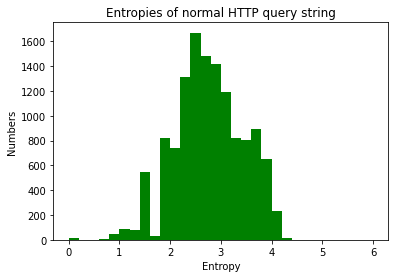

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

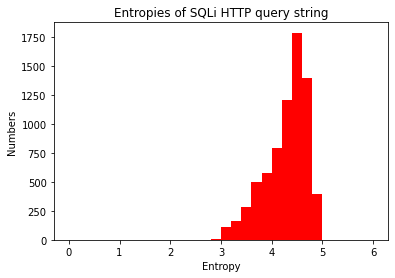

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

In [11]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


In [12]:
print('{:.2%}'.format(df_sqli['payload'].str.contains('\)').sum() / len(df_sqli['payload'])))

90.91%


In [13]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(df_norm['payload'].str.contains('\)').sum() / len(df_norm['payload'])))

0.01%


In [14]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [15]:
df = func_preprocessing(df)

In [16]:
df

,payload,length,attack_type,label,entropy,closing_parenthesis
0,c/ caridad s/n,14,norm,0,3.093069,0
1,"campello, el",12,norm,0,3.022055,0
2,1442431887503330,16,norm,0,2.827820,0
3,nue37,5,norm,0,2.321928,0
4,tufts3@joll.rs,14,norm,0,3.378783,0
...,...,...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,1,4.064392,1
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,1,4.718866,1
20362,"1"" order by 1--",15,sqli,1,3.189898,0
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,1,4.641613,1


In [17]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

In [18]:
X_all

,length,entropy,closing_parenthesis
0,14,3.093069,0
1,12,3.022055,0
2,16,2.827820,0
3,5,2.321928,0
4,14,3.378783,0
...,...,...,...
10176,113,4.422041,1
10177,113,4.514233,1
10178,136,4.630369,1
10179,111,4.539371,1


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate


class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 64)
        }
        model = DecisionTreeClassifier(**params)
        # 交差検証の設定
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=kf,
                                scoring='neg_log_loss',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_all, y_all)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2021-09-05 02:06:26,533] A new study created in memory with name: no-name-f24cb423-70d6-4c63-b841-ba18b201a272
[I 2021-09-05 02:06:27,582] Trial 0 finished with value: -0.4011510115375942 and parameters: {'criterion': 'entropy', 'max_depth': 21}. Best is trial 0 with value: -0.4011510115375942.
[I 2021-09-05 02:06:27,701] Trial 1 finished with value: -0.43719151662687433 and parameters: {'criterion': 'entropy', 'max_depth': 43}. Best is trial 1 with value: -0.43719151662687433.
[I 2021-09-05 02:06:27,799] Trial 2 finished with value: -0.055345476354751066 and parameters: {'criterion': 'entropy', 'max_depth': 3}. Best is trial 1 with value: -0.43719151662687433.
[I 2021-09-05 02:06:27,917] Trial 3 finished with value: -0.43495266536909866 and parameters: {'criterion': 'entropy', 'max_depth': 58}. Best is trial 1 with value: -0.43719151662687433.
[I 2021-09-05 02:06:28,006] Trial 4 finished with value: -0.055345476354751066 and parameters: {'criterion': 'entropy', 'max_depth': 3}. Bes

params: {'criterion': 'gini', 'max_depth': 47}


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

#ハイパーパラメータチューニングで特定した値を設定

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 98.17639 %
[[3808   39]
 [  71 2114]]


In [21]:
import pandas as pd

# データセットを再ロードする
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]

df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

rep = y_all.label.replace({"norm":0,"anom":1})
y_all = y_all.assign(label=rep)

In [22]:
X_all

,payload,length,attack_type
0,c/ caridad s/n,14,norm
1,"campello, el",12,norm
2,1442431887503330,16,norm
3,nue37,5,norm
4,tufts3@joll.rs,14,norm
...,...,...,...
10176,"1"") where 2367=2367;select (case when (4666=46...",113,sqli
10177,"1') and updatexml(3393,concat(0x2e,0x7171706a7...",113,sqli
10178,1') as tqdg where 9355=9355;select (case when ...,136,sqli
10179,"1') and extractvalue(7982,concat(0x5c,0x717170...",111,sqli


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

# ベクトル化のためのオプションの設定、文字を対象にユニグラムを行う
vec_opts = {
    "ngram_range": (1, 1), 
    "analyzer": "char", 
    "min_df" : 0.1
}

# TfidfVectorizerの初期化
v = TfidfVectorizer(**vec_opts)
# ベクトル化の実行
X = v.fit_transform(X)

In [24]:
import numpy as np

# 特徴に使用されている文字を出力
features = v.get_feature_names()
np.array(features)

array([' ', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y'], dtype='<U1')

In [25]:
df = pd.DataFrame(X.toarray())
df.columns = features
df

,,"""",',(,),*,",",-,.,0,1,2,3,4,5,6,7,8,9,=,a,b,c,d,e,f,g,h,i,k,l,m,n,o,p,r,s,t,u,v,w,x,y
0,0.453262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367518,0.000000,0.460722,0.504676,0.000000,0.000000,0.000000,0.000000,0.231185,0.000000,0.000000,0.000000,0.213771,0.000000,0.000000,0.209315,0.222629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.223881,0.000000,0.000000,0.000000,0.000000,0.000000,0.297448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181529,0.000000,0.227566,0.000000,0.379535,0.000000,0.000000,0.000000,0.000000,0.000000,0.637700,0.279457,0.000000,0.211999,0.320803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316555,0.257108,0.154605,0.637142,0.493407,0.150187,0.000000,0.165919,0.332115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.488536,0.000000,0.000000,0.000000,0.508881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.342872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381555,0.000000,0.000000,0.000000,0.000000,0.000000,0.489108,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382917,0.000000,0.000000,0.000000,0.259419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310430,0.000000,0.000000,0.000000,0.000000,0.407889,0.000000,0.000000,0.203400,0.000000,0.198388,0.422014,0.443910,0.259723,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30151,0.427799,0.061067,0.000000,0.132674,0.162360,0.062953,0.000000,0.096652,0.117327,0.000000,0.064151,0.077151,0.079487,0.164146,0.000000,0.562813,0.082797,0.000000,0.000000,0.086371,0.133412,0.046812,0.100347,0.073281,0.390506,0.047558,0.000000,0.131508,0.000000,0.000000,0.093734,0.082153,0.093121,0.031161,0.000000,0.091180,0.290938,0.170019,0.000000,0.000000,0.100595,0.000000,0.056381
30152,0.166014,0.000000,0.208435,0.267729,0.245725,0.000000,0.264680,0.000000,0.000000,0.159385,0.323633,0.038922,0.360899,0.000000,0.000000,0.121685,0.375929,0.000000,0.129710,0.087146,0.188453,0.000000,0.101248,0.110907,0.140718,0.000000,0.100469,0.000000,0.000000,0.000000,0.094575,0.041445,0.156594,0.031441,0.047577,0.000000,0.032617,0.137235,0.040147,0.000000,0.000000,0.369485,0.000000
30153,0.468956,0.000000,0.049065,0.126046,0.154249,0.059808,0.000000,0.000000,0.055733,0.000000,0.030473,0.183243,0.075516,0.000000,0.142405,0.381927,0.196652,0.000000,0.081423,0.082057,0.152097,0.000000,0.190669,0.069620,0.397499,0.090365,0.047301,0.208231,0.063784,0.000000,0.089051,0.117074,0.147448,0.088813,0.000000,0.144375,0.245693,0.226136,0.000000,0.000000,0.095570,0.000000,0.000000
30154,0.171542,0.000000,0.215375,0.276644,0.253907,0.000000,0.227911,0.000000,0.000000,0.164692,0.234086,0.120653,0.000000,0.000000,0.039068,0.083825,0.517929,0.129590,0.134029,0.090048,0.222546,0.000000,0.174366,0.152800,0.203565,0.000000,0.000000,0.000000,0.000000,0.121721,0.097724,0.000000,0.097085,0.032488,0.000000,0.031687,0.033703,0.177256,0.041484,0.188331,0.000000,0.254525,0.000000


In [26]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, num_boost_round=100, folds=StratifiedKFold(n_splits=5))

# ハイパーパラメータ探索の実行
tuner.run()

[I 2021-09-05 02:07:27,359] A new study created in memory with name: no-name-a32a6868-af14-4221-825b-6da103c1c074
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.563085 + 0.000127238
[2]	cv_agg's binary_logloss: 0.491301 + 0.000235022
[3]	cv_agg's binary_logloss: 0.429875 + 0.00022155
[4]	cv_agg's binary_logloss: 0.377655 + 0.000225486
[5]	cv_agg's binary_logloss: 0.333845 + 0.00024096
[6]	cv_agg's binary_logloss: 0.296493 + 0.000315298
[7]	cv_agg's binary_logloss: 0.264678 + 0.000402564
[8]	cv_agg's binary_logloss: 0.235714 + 0.0003721
[9]	cv_agg's binary_logloss: 0.210674 + 0.000337405
[10]	cv_agg's binary_logloss: 0.19069 + 0.000384003
[11]	cv_agg's binary_logloss: 0.171495 + 0.000307194
[12]	cv_agg's binary_logloss: 0.154041 + 0.000302485
[13]	cv_agg's binary_logloss: 0.138625 + 0.000262536
[14]	cv_agg's binary_logloss: 0.125468 + 0.000220484
[15]	cv_agg's binary_logloss: 0.11295 + 0.000223758
[16]	cv_agg's binary_logloss: 0.101908 + 0.000203318
[17]	cv_agg's binary_logloss: 0.091891 + 0.000186579
[18]	cv_agg's binary_logloss: 0.0829826 + 0.000164271
[19]	cv_agg's binary_logloss: 0.0748987 + 0.00014571
[20]	cv

feature_fraction, val_score: 0.001173:  14%|#4        | 1/7 [00:02<00:14,  2.33s/it]

[99]	cv_agg's binary_logloss: 0.00115921 + 0.000753136
[100]	cv_agg's binary_logloss: 0.00117304 + 0.000764567
[1]	cv_agg's binary_logloss: 0.558852 + 0.000189222
[2]	cv_agg's binary_logloss: 0.484081 + 0.000250311
[3]	cv_agg's binary_logloss: 0.42309 + 0.000286627
[4]	cv_agg's binary_logloss: 0.371962 + 0.000345454
[5]	cv_agg's binary_logloss: 0.328489 + 0.000437578
[6]	cv_agg's binary_logloss: 0.291125 + 0.000488768
[7]	cv_agg's binary_logloss: 0.259054 + 0.000451822
[8]	cv_agg's binary_logloss: 0.230967 + 0.000446468
[9]	cv_agg's binary_logloss: 0.206394 + 0.000464139
[10]	cv_agg's binary_logloss: 0.184815 + 0.000485636
[11]	cv_agg's binary_logloss: 0.165961 + 0.000459659
[12]	cv_agg's binary_logloss: 0.148924 + 0.000482692
[13]	cv_agg's binary_logloss: 0.133904 + 0.000469446
[14]	cv_agg's binary_logloss: 0.120711 + 0.000474141
[15]	cv_agg's binary_logloss: 0.108702 + 0.000523674
[16]	cv_agg's binary_logloss: 0.0980776 + 0.000529909
[17]	cv_agg's binary_logloss: 0.0884757 + 0.000537

feature_fraction, val_score: 0.001173:  29%|##8       | 2/7 [00:05<00:14,  2.92s/it]

[99]	cv_agg's binary_logloss: 0.00189738 + 0.00120233
[100]	cv_agg's binary_logloss: 0.00189494 + 0.00120489
[1]	cv_agg's binary_logloss: 0.558813 + 0.000211653
[2]	cv_agg's binary_logloss: 0.484161 + 0.000399333
[3]	cv_agg's binary_logloss: 0.422995 + 0.000523324
[4]	cv_agg's binary_logloss: 0.371813 + 0.000622354
[5]	cv_agg's binary_logloss: 0.328482 + 0.000747259
[6]	cv_agg's binary_logloss: 0.291305 + 0.000808716
[7]	cv_agg's binary_logloss: 0.259111 + 0.000847048
[8]	cv_agg's binary_logloss: 0.23111 + 0.000902446
[9]	cv_agg's binary_logloss: 0.206601 + 0.000952186
[10]	cv_agg's binary_logloss: 0.185015 + 0.000963349
[11]	cv_agg's binary_logloss: 0.165991 + 0.000977487
[12]	cv_agg's binary_logloss: 0.149147 + 0.00100648
[13]	cv_agg's binary_logloss: 0.134166 + 0.00102007
[14]	cv_agg's binary_logloss: 0.12086 + 0.00100466
[15]	cv_agg's binary_logloss: 0.108991 + 0.0010109
[16]	cv_agg's binary_logloss: 0.0983709 + 0.00102829
[17]	cv_agg's binary_logloss: 0.0888467 + 0.00101581
[18]	c

feature_fraction, val_score: 0.001173:  43%|####2     | 3/7 [00:09<00:13,  3.33s/it]

[97]	cv_agg's binary_logloss: 0.00298484 + 0.00157822
[98]	cv_agg's binary_logloss: 0.00299119 + 0.00156418
[99]	cv_agg's binary_logloss: 0.00300679 + 0.00158144
[100]	cv_agg's binary_logloss: 0.00301344 + 0.0015852
[1]	cv_agg's binary_logloss: 0.558978 + 0.000203896
[2]	cv_agg's binary_logloss: 0.484175 + 0.000248178
[3]	cv_agg's binary_logloss: 0.422991 + 0.00033478
[4]	cv_agg's binary_logloss: 0.371831 + 0.000405969
[5]	cv_agg's binary_logloss: 0.328384 + 0.000496812
[6]	cv_agg's binary_logloss: 0.291106 + 0.000572349
[7]	cv_agg's binary_logloss: 0.259072 + 0.000590081
[8]	cv_agg's binary_logloss: 0.231035 + 0.000666648
[9]	cv_agg's binary_logloss: 0.206373 + 0.000711304
[10]	cv_agg's binary_logloss: 0.18474 + 0.00070441
[11]	cv_agg's binary_logloss: 0.165912 + 0.000667307
[12]	cv_agg's binary_logloss: 0.148917 + 0.000689714
[13]	cv_agg's binary_logloss: 0.133917 + 0.000701096
[14]	cv_agg's binary_logloss: 0.120542 + 0.000690609
[15]	cv_agg's binary_logloss: 0.108625 + 0.000701367
[

feature_fraction, val_score: 0.001173:  57%|#####7    | 4/7 [00:13<00:10,  3.42s/it]

[95]	cv_agg's binary_logloss: 0.00230273 + 0.0012823
[96]	cv_agg's binary_logloss: 0.00231237 + 0.0013012
[97]	cv_agg's binary_logloss: 0.0023192 + 0.00132026
[98]	cv_agg's binary_logloss: 0.00233531 + 0.00134139
[99]	cv_agg's binary_logloss: 0.0023429 + 0.00135115
[100]	cv_agg's binary_logloss: 0.00235411 + 0.00137145
[1]	cv_agg's binary_logloss: 0.562061 + 0.000444092
[2]	cv_agg's binary_logloss: 0.490145 + 0.000494629
[3]	cv_agg's binary_logloss: 0.428302 + 0.000573509
[4]	cv_agg's binary_logloss: 0.376343 + 0.000500743
[5]	cv_agg's binary_logloss: 0.332175 + 0.000453367
[6]	cv_agg's binary_logloss: 0.294792 + 0.00039037
[7]	cv_agg's binary_logloss: 0.262099 + 0.000412747
[8]	cv_agg's binary_logloss: 0.233465 + 0.000384291
[9]	cv_agg's binary_logloss: 0.208692 + 0.000402071
[10]	cv_agg's binary_logloss: 0.186796 + 0.000401841
[11]	cv_agg's binary_logloss: 0.168136 + 0.000386383
[12]	cv_agg's binary_logloss: 0.150857 + 0.000426499
[13]	cv_agg's binary_logloss: 0.135627 + 0.000390222


feature_fraction, val_score: 0.001151:  71%|#######1  | 5/7 [00:15<00:06,  3.10s/it]

[99]	cv_agg's binary_logloss: 0.0011365 + 0.000676734
[100]	cv_agg's binary_logloss: 0.00115086 + 0.000685716
[1]	cv_agg's binary_logloss: 0.559633 + 0.000239098
[2]	cv_agg's binary_logloss: 0.484708 + 0.0002924
[3]	cv_agg's binary_logloss: 0.423727 + 0.000378041
[4]	cv_agg's binary_logloss: 0.372634 + 0.000275425
[5]	cv_agg's binary_logloss: 0.329014 + 0.000333703
[6]	cv_agg's binary_logloss: 0.291614 + 0.000434642
[7]	cv_agg's binary_logloss: 0.259525 + 0.000511396
[8]	cv_agg's binary_logloss: 0.231234 + 0.00053031
[9]	cv_agg's binary_logloss: 0.20666 + 0.000518601
[10]	cv_agg's binary_logloss: 0.184981 + 0.000539875
[11]	cv_agg's binary_logloss: 0.16596 + 0.000523347
[12]	cv_agg's binary_logloss: 0.148948 + 0.000542681
[13]	cv_agg's binary_logloss: 0.13386 + 0.000522371
[14]	cv_agg's binary_logloss: 0.121003 + 0.000502444
[15]	cv_agg's binary_logloss: 0.108942 + 0.000531882
[16]	cv_agg's binary_logloss: 0.0982069 + 0.000524779
[17]	cv_agg's binary_logloss: 0.0885733 + 0.000510217
[1

feature_fraction, val_score: 0.001151:  86%|########5 | 6/7 [00:18<00:03,  3.11s/it]

[95]	cv_agg's binary_logloss: 0.00156432 + 0.00083607
[96]	cv_agg's binary_logloss: 0.00157519 + 0.000842985
[97]	cv_agg's binary_logloss: 0.00158809 + 0.000843704
[98]	cv_agg's binary_logloss: 0.00160373 + 0.000860078
[99]	cv_agg's binary_logloss: 0.00160922 + 0.000887979
[100]	cv_agg's binary_logloss: 0.00162055 + 0.000905295
[1]	cv_agg's binary_logloss: 0.559657 + 0.000235734
[2]	cv_agg's binary_logloss: 0.484857 + 0.000371394
[3]	cv_agg's binary_logloss: 0.423861 + 0.000411452
[4]	cv_agg's binary_logloss: 0.372648 + 0.000373085
[5]	cv_agg's binary_logloss: 0.328989 + 0.000392372
[6]	cv_agg's binary_logloss: 0.292011 + 0.000320166
[7]	cv_agg's binary_logloss: 0.259754 + 0.000362875
[8]	cv_agg's binary_logloss: 0.231444 + 0.000385566
[9]	cv_agg's binary_logloss: 0.206885 + 0.000382832
[10]	cv_agg's binary_logloss: 0.185161 + 0.000402194
[11]	cv_agg's binary_logloss: 0.166112 + 0.000395336
[12]	cv_agg's binary_logloss: 0.149056 + 0.000413984
[13]	cv_agg's binary_logloss: 0.134044 + 0.

feature_fraction, val_score: 0.001151: 100%|##########| 7/7 [00:21<00:00,  3.07s/it]


[97]	cv_agg's binary_logloss: 0.00132815 + 0.000795865
[98]	cv_agg's binary_logloss: 0.00133047 + 0.000806201
[99]	cv_agg's binary_logloss: 0.00134181 + 0.000818738
[100]	cv_agg's binary_logloss: 0.00135099 + 0.000840922


num_leaves, val_score: 0.001151:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.562631 + 0.000526921
[2]	cv_agg's binary_logloss: 0.490926 + 0.000523124
[3]	cv_agg's binary_logloss: 0.428953 + 0.000533491
[4]	cv_agg's binary_logloss: 0.376894 + 0.000504355
[5]	cv_agg's binary_logloss: 0.332644 + 0.000473376
[6]	cv_agg's binary_logloss: 0.295216 + 0.000416487
[7]	cv_agg's binary_logloss: 0.262455 + 0.000427464
[8]	cv_agg's binary_logloss: 0.233773 + 0.000399269
[9]	cv_agg's binary_logloss: 0.20898 + 0.000405244
[10]	cv_agg's binary_logloss: 0.187056 + 0.000397878
[11]	cv_agg's binary_logloss: 0.168478 + 0.000437361
[12]	cv_agg's binary_logloss: 0.151157 + 0.000474357
[13]	cv_agg's binary_logloss: 0.135909 + 0.000432113
[14]	cv_agg's binary_logloss: 0.123118 + 0.000484523
[15]	cv_agg's binary_logloss: 0.11086 + 0.000447973
[16]	cv_agg's binary_logloss: 0.100051 + 0.000433712
[17]	cv_agg's binary_logloss: 0.0901931 + 0.000398244
[18]	cv_agg's binary_logloss: 0.0814613 + 0.000372992
[19]	cv_agg's binary_logloss: 0.0735586 + 0.000371965
[

num_leaves, val_score: 0.001151:   5%|5         | 1/20 [00:02<00:45,  2.37s/it]

[95]	cv_agg's binary_logloss: 0.00113187 + 0.0006257
[96]	cv_agg's binary_logloss: 0.00114284 + 0.000619863
[97]	cv_agg's binary_logloss: 0.00114733 + 0.000629932
[98]	cv_agg's binary_logloss: 0.00115636 + 0.000646633
[99]	cv_agg's binary_logloss: 0.00116667 + 0.000663564
[100]	cv_agg's binary_logloss: 0.00117907 + 0.000673239
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489127 + 0.000426941
[3]	cv_agg's binary_logloss: 0.427459 + 0.000489066
[4]	cv_agg's binary_logloss: 0.37565 + 0.000419751
[5]	cv_agg's binary_logloss: 0.331595 + 0.000417755
[6]	cv_agg's binary_logloss: 0.294249 + 0.00035165
[7]	cv_agg's binary_logloss: 0.261634 + 0.000377526
[8]	cv_agg's binary_logloss: 0.233069 + 0.000346965
[9]	cv_agg's binary_logloss: 0.208351 + 0.000357496
[10]	cv_agg's binary_logloss: 0.186498 + 0.000369702
[11]	cv_agg's binary_logloss: 0.16775 + 0.000371833
[12]	cv_agg's binary_logloss: 0.150518 + 0.00040083
[13]	cv_agg's binary_logloss: 0.135317 + 0.00033

num_leaves, val_score: 0.001146:  10%|#         | 2/20 [00:11<01:57,  6.53s/it]

[99]	cv_agg's binary_logloss: 0.00113128 + 0.000716184
[100]	cv_agg's binary_logloss: 0.00114637 + 0.00072442
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.48913 + 0.000420457
[3]	cv_agg's binary_logloss: 0.427463 + 0.00048375
[4]	cv_agg's binary_logloss: 0.37565 + 0.000413154
[5]	cv_agg's binary_logloss: 0.331594 + 0.000411819
[6]	cv_agg's binary_logloss: 0.294247 + 0.000345386
[7]	cv_agg's binary_logloss: 0.261629 + 0.000368484
[8]	cv_agg's binary_logloss: 0.233064 + 0.000336509
[9]	cv_agg's binary_logloss: 0.208349 + 0.000350336
[10]	cv_agg's binary_logloss: 0.186494 + 0.000362149
[11]	cv_agg's binary_logloss: 0.167753 + 0.000364623
[12]	cv_agg's binary_logloss: 0.150521 + 0.000394506
[13]	cv_agg's binary_logloss: 0.135315 + 0.000336311
[14]	cv_agg's binary_logloss: 0.122289 + 0.000337958
[15]	cv_agg's binary_logloss: 0.110108 + 0.000332278
[16]	cv_agg's binary_logloss: 0.0993571 + 0.000327219
[17]	cv_agg's binary_logloss: 0.0895879 + 0.000289243

num_leaves, val_score: 0.001146:  15%|#5        | 3/20 [00:17<01:40,  5.93s/it]

[100]	cv_agg's binary_logloss: 0.00116179 + 0.00073217
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489128 + 0.000422866
[3]	cv_agg's binary_logloss: 0.427457 + 0.000486893
[4]	cv_agg's binary_logloss: 0.375643 + 0.000416135
[5]	cv_agg's binary_logloss: 0.331593 + 0.000413361
[6]	cv_agg's binary_logloss: 0.294245 + 0.000346449
[7]	cv_agg's binary_logloss: 0.261629 + 0.000372868
[8]	cv_agg's binary_logloss: 0.233064 + 0.000340597
[9]	cv_agg's binary_logloss: 0.208347 + 0.000353547
[10]	cv_agg's binary_logloss: 0.186494 + 0.000366071
[11]	cv_agg's binary_logloss: 0.167752 + 0.000367368
[12]	cv_agg's binary_logloss: 0.150519 + 0.000397108
[13]	cv_agg's binary_logloss: 0.135318 + 0.00033256
[14]	cv_agg's binary_logloss: 0.122294 + 0.000332929
[15]	cv_agg's binary_logloss: 0.110113 + 0.000327232
[16]	cv_agg's binary_logloss: 0.099361 + 0.000324774
[17]	cv_agg's binary_logloss: 0.0895913 + 0.000286988
[18]	cv_agg's binary_logloss: 0.0809292 + 0.000266153

num_leaves, val_score: 0.001128:  20%|##        | 4/20 [00:22<01:34,  5.93s/it]

[98]	cv_agg's binary_logloss: 0.00110056 + 0.000693198
[99]	cv_agg's binary_logloss: 0.00111322 + 0.000709238
[100]	cv_agg's binary_logloss: 0.00112849 + 0.000717284
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489127 + 0.000426938
[3]	cv_agg's binary_logloss: 0.427459 + 0.000488976
[4]	cv_agg's binary_logloss: 0.375649 + 0.000421257
[5]	cv_agg's binary_logloss: 0.331593 + 0.000419699
[6]	cv_agg's binary_logloss: 0.294248 + 0.000354087
[7]	cv_agg's binary_logloss: 0.261633 + 0.000380046
[8]	cv_agg's binary_logloss: 0.233068 + 0.000349316
[9]	cv_agg's binary_logloss: 0.20835 + 0.000359744
[10]	cv_agg's binary_logloss: 0.186496 + 0.0003707
[11]	cv_agg's binary_logloss: 0.167748 + 0.000374024
[12]	cv_agg's binary_logloss: 0.150516 + 0.000402639
[13]	cv_agg's binary_logloss: 0.135315 + 0.000337996
[14]	cv_agg's binary_logloss: 0.122293 + 0.000340405
[15]	cv_agg's binary_logloss: 0.110111 + 0.000334425
[16]	cv_agg's binary_logloss: 0.0993598 + 0.0003275

num_leaves, val_score: 0.001128:  25%|##5       | 5/20 [00:32<01:46,  7.08s/it]

[100]	cv_agg's binary_logloss: 0.00114635 + 0.000724357
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489129 + 0.000422701
[3]	cv_agg's binary_logloss: 0.427458 + 0.000486983
[4]	cv_agg's binary_logloss: 0.375645 + 0.000418563
[5]	cv_agg's binary_logloss: 0.331592 + 0.000415426
[6]	cv_agg's binary_logloss: 0.294244 + 0.0003494
[7]	cv_agg's binary_logloss: 0.261629 + 0.000375007
[8]	cv_agg's binary_logloss: 0.233063 + 0.000342142
[9]	cv_agg's binary_logloss: 0.208346 + 0.000354795
[10]	cv_agg's binary_logloss: 0.186493 + 0.000367126
[11]	cv_agg's binary_logloss: 0.167751 + 0.000368263
[12]	cv_agg's binary_logloss: 0.150519 + 0.000398333
[13]	cv_agg's binary_logloss: 0.135318 + 0.000334021
[14]	cv_agg's binary_logloss: 0.122296 + 0.000336986
[15]	cv_agg's binary_logloss: 0.110114 + 0.000330861
[16]	cv_agg's binary_logloss: 0.0993636 + 0.000328279
[17]	cv_agg's binary_logloss: 0.0895938 + 0.000290158
[18]	cv_agg's binary_logloss: 0.0809316 + 0.00026894

num_leaves, val_score: 0.001128:  30%|###       | 6/20 [00:37<01:33,  6.66s/it]

[98]	cv_agg's binary_logloss: 0.00110597 + 0.000691617
[99]	cv_agg's binary_logloss: 0.00111831 + 0.000708018
[100]	cv_agg's binary_logloss: 0.00113331 + 0.00071616
[1]	cv_agg's binary_logloss: 0.561689 + 0.000274458
[2]	cv_agg's binary_logloss: 0.489409 + 0.000498347
[3]	cv_agg's binary_logloss: 0.427703 + 0.000515264
[4]	cv_agg's binary_logloss: 0.375845 + 0.000431082
[5]	cv_agg's binary_logloss: 0.331762 + 0.00043557
[6]	cv_agg's binary_logloss: 0.294392 + 0.000358477
[7]	cv_agg's binary_logloss: 0.261763 + 0.000404124
[8]	cv_agg's binary_logloss: 0.233181 + 0.000365656
[9]	cv_agg's binary_logloss: 0.208448 + 0.000374457
[10]	cv_agg's binary_logloss: 0.186579 + 0.000393186
[11]	cv_agg's binary_logloss: 0.167866 + 0.000428977
[12]	cv_agg's binary_logloss: 0.150617 + 0.000454142
[13]	cv_agg's binary_logloss: 0.135396 + 0.000387835
[14]	cv_agg's binary_logloss: 0.122435 + 0.000395359
[15]	cv_agg's binary_logloss: 0.110249 + 0.00037217
[16]	cv_agg's binary_logloss: 0.0994711 + 0.0003766

num_leaves, val_score: 0.001128:  35%|###5      | 7/20 [00:40<01:10,  5.45s/it]

[96]	cv_agg's binary_logloss: 0.00110144 + 0.000652915
[97]	cv_agg's binary_logloss: 0.00110592 + 0.000664141
[98]	cv_agg's binary_logloss: 0.00111386 + 0.000682423
[99]	cv_agg's binary_logloss: 0.00112141 + 0.000696976
[100]	cv_agg's binary_logloss: 0.00113312 + 0.00070893
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000426839
[3]	cv_agg's binary_logloss: 0.427459 + 0.000489114
[4]	cv_agg's binary_logloss: 0.375651 + 0.000420043
[5]	cv_agg's binary_logloss: 0.331597 + 0.000416833
[6]	cv_agg's binary_logloss: 0.294252 + 0.000352005
[7]	cv_agg's binary_logloss: 0.261636 + 0.000378034
[8]	cv_agg's binary_logloss: 0.23307 + 0.000347274
[9]	cv_agg's binary_logloss: 0.208352 + 0.000358234
[10]	cv_agg's binary_logloss: 0.186498 + 0.000370467
[11]	cv_agg's binary_logloss: 0.167751 + 0.000372606
[12]	cv_agg's binary_logloss: 0.150518 + 0.000401334
[13]	cv_agg's binary_logloss: 0.135317 + 0.00033691
[14]	cv_agg's binary_logloss: 0.122295 + 0.0003

num_leaves, val_score: 0.001128:  40%|####      | 8/20 [00:49<01:15,  6.33s/it]

[100]	cv_agg's binary_logloss: 0.00113694 + 0.000731555
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000427022
[3]	cv_agg's binary_logloss: 0.427458 + 0.000488179
[4]	cv_agg's binary_logloss: 0.375646 + 0.000412828
[5]	cv_agg's binary_logloss: 0.331593 + 0.000410031
[6]	cv_agg's binary_logloss: 0.294247 + 0.000344594
[7]	cv_agg's binary_logloss: 0.26163 + 0.000369432
[8]	cv_agg's binary_logloss: 0.233065 + 0.000338986
[9]	cv_agg's binary_logloss: 0.208349 + 0.000351531
[10]	cv_agg's binary_logloss: 0.186495 + 0.00036423
[11]	cv_agg's binary_logloss: 0.167747 + 0.000367711
[12]	cv_agg's binary_logloss: 0.150515 + 0.000397368
[13]	cv_agg's binary_logloss: 0.135314 + 0.000332342
[14]	cv_agg's binary_logloss: 0.122292 + 0.000335764
[15]	cv_agg's binary_logloss: 0.110111 + 0.000329946
[16]	cv_agg's binary_logloss: 0.0993534 + 0.000325732
[17]	cv_agg's binary_logloss: 0.0895837 + 0.000287234
[18]	cv_agg's binary_logloss: 0.0809217 + 0.00026520

num_leaves, val_score: 0.001128:  45%|####5     | 9/20 [00:56<01:12,  6.63s/it]

[99]	cv_agg's binary_logloss: 0.00112036 + 0.000717729
[100]	cv_agg's binary_logloss: 0.00113232 + 0.000729802
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.48913 + 0.000421562
[3]	cv_agg's binary_logloss: 0.427465 + 0.000487553
[4]	cv_agg's binary_logloss: 0.375652 + 0.000417777
[5]	cv_agg's binary_logloss: 0.331596 + 0.000414666
[6]	cv_agg's binary_logloss: 0.29425 + 0.000350695
[7]	cv_agg's binary_logloss: 0.261631 + 0.000371622
[8]	cv_agg's binary_logloss: 0.233065 + 0.000338884
[9]	cv_agg's binary_logloss: 0.20835 + 0.000352213
[10]	cv_agg's binary_logloss: 0.186496 + 0.000365631
[11]	cv_agg's binary_logloss: 0.167754 + 0.000367601
[12]	cv_agg's binary_logloss: 0.150521 + 0.000397219
[13]	cv_agg's binary_logloss: 0.135316 + 0.000338883
[14]	cv_agg's binary_logloss: 0.12229 + 0.000340084
[15]	cv_agg's binary_logloss: 0.110109 + 0.000334335
[16]	cv_agg's binary_logloss: 0.0993582 + 0.000329027
[17]	cv_agg's binary_logloss: 0.0895887 + 0.000290841

num_leaves, val_score: 0.001128:  50%|#####     | 10/20 [01:01<01:02,  6.22s/it]

[99]	cv_agg's binary_logloss: 0.00114095 + 0.00070836
[100]	cv_agg's binary_logloss: 0.00115196 + 0.000720322
[1]	cv_agg's binary_logloss: 0.561623 + 0.000243489
[2]	cv_agg's binary_logloss: 0.489149 + 0.000411844
[3]	cv_agg's binary_logloss: 0.427475 + 0.000467108
[4]	cv_agg's binary_logloss: 0.375658 + 0.000393522
[5]	cv_agg's binary_logloss: 0.331602 + 0.000390036
[6]	cv_agg's binary_logloss: 0.294253 + 0.000329097
[7]	cv_agg's binary_logloss: 0.261633 + 0.000354461
[8]	cv_agg's binary_logloss: 0.233068 + 0.000323493
[9]	cv_agg's binary_logloss: 0.208352 + 0.000338675
[10]	cv_agg's binary_logloss: 0.186496 + 0.000351662
[11]	cv_agg's binary_logloss: 0.16775 + 0.00036077
[12]	cv_agg's binary_logloss: 0.150516 + 0.000391344
[13]	cv_agg's binary_logloss: 0.135311 + 0.000333538
[14]	cv_agg's binary_logloss: 0.122292 + 0.000336941
[15]	cv_agg's binary_logloss: 0.110108 + 0.00032977
[16]	cv_agg's binary_logloss: 0.099358 + 0.000323976
[17]	cv_agg's binary_logloss: 0.0895883 + 0.000286196


num_leaves, val_score: 0.001128:  55%|#####5    | 11/20 [01:05<00:49,  5.54s/it]

[99]	cv_agg's binary_logloss: 0.00113712 + 0.000712354
[100]	cv_agg's binary_logloss: 0.00114911 + 0.000723903
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000426922
[3]	cv_agg's binary_logloss: 0.427458 + 0.00048796
[4]	cv_agg's binary_logloss: 0.375648 + 0.000413628
[5]	cv_agg's binary_logloss: 0.331594 + 0.000409614
[6]	cv_agg's binary_logloss: 0.294247 + 0.000343822
[7]	cv_agg's binary_logloss: 0.261631 + 0.000368962
[8]	cv_agg's binary_logloss: 0.233065 + 0.000338887
[9]	cv_agg's binary_logloss: 0.208349 + 0.00035151
[10]	cv_agg's binary_logloss: 0.186495 + 0.000364189
[11]	cv_agg's binary_logloss: 0.167747 + 0.000367641
[12]	cv_agg's binary_logloss: 0.150515 + 0.000397348
[13]	cv_agg's binary_logloss: 0.135314 + 0.000332791
[14]	cv_agg's binary_logloss: 0.122292 + 0.000336003
[15]	cv_agg's binary_logloss: 0.110111 + 0.000330123
[16]	cv_agg's binary_logloss: 0.0993534 + 0.000325825
[17]	cv_agg's binary_logloss: 0.0895836 + 0.0002873

num_leaves, val_score: 0.001128:  60%|######    | 12/20 [01:13<00:48,  6.11s/it]

[100]	cv_agg's binary_logloss: 0.00113778 + 0.000729692
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000425225
[3]	cv_agg's binary_logloss: 0.427458 + 0.000486751
[4]	cv_agg's binary_logloss: 0.375646 + 0.000409483
[5]	cv_agg's binary_logloss: 0.331592 + 0.000408183
[6]	cv_agg's binary_logloss: 0.294246 + 0.000342662
[7]	cv_agg's binary_logloss: 0.261629 + 0.000367256
[8]	cv_agg's binary_logloss: 0.233064 + 0.000336865
[9]	cv_agg's binary_logloss: 0.208348 + 0.000350217
[10]	cv_agg's binary_logloss: 0.186493 + 0.000362238
[11]	cv_agg's binary_logloss: 0.167746 + 0.000366197
[12]	cv_agg's binary_logloss: 0.150515 + 0.00039562
[13]	cv_agg's binary_logloss: 0.135314 + 0.000331017
[14]	cv_agg's binary_logloss: 0.122292 + 0.000334842
[15]	cv_agg's binary_logloss: 0.110111 + 0.000329146
[16]	cv_agg's binary_logloss: 0.0993609 + 0.000322703
[17]	cv_agg's binary_logloss: 0.0895913 + 0.000284791
[18]	cv_agg's binary_logloss: 0.080929 + 0.00026355

num_leaves, val_score: 0.001125:  65%|######5   | 13/20 [01:20<00:44,  6.36s/it]

[99]	cv_agg's binary_logloss: 0.00111063 + 0.000705375
[100]	cv_agg's binary_logloss: 0.00112525 + 0.000713498
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489125 + 0.00042632
[3]	cv_agg's binary_logloss: 0.427457 + 0.000487683
[4]	cv_agg's binary_logloss: 0.375645 + 0.000409259
[5]	cv_agg's binary_logloss: 0.331592 + 0.000407939
[6]	cv_agg's binary_logloss: 0.294245 + 0.000342058
[7]	cv_agg's binary_logloss: 0.261629 + 0.000366749
[8]	cv_agg's binary_logloss: 0.233064 + 0.000336279
[9]	cv_agg's binary_logloss: 0.208348 + 0.000349444
[10]	cv_agg's binary_logloss: 0.186495 + 0.000362369
[11]	cv_agg's binary_logloss: 0.167746 + 0.000366215
[12]	cv_agg's binary_logloss: 0.150515 + 0.000395925
[13]	cv_agg's binary_logloss: 0.135314 + 0.000331453
[14]	cv_agg's binary_logloss: 0.122292 + 0.000334952
[15]	cv_agg's binary_logloss: 0.110111 + 0.000329265
[16]	cv_agg's binary_logloss: 0.099361 + 0.000323106
[17]	cv_agg's binary_logloss: 0.0895912 + 0.0002852

num_leaves, val_score: 0.001125:  70%|#######   | 14/20 [01:27<00:39,  6.57s/it]

[99]	cv_agg's binary_logloss: 0.00112123 + 0.000722744
[100]	cv_agg's binary_logloss: 0.00113597 + 0.000730988
[1]	cv_agg's binary_logloss: 0.561627 + 0.00024326
[2]	cv_agg's binary_logloss: 0.489143 + 0.000416345
[3]	cv_agg's binary_logloss: 0.427472 + 0.000474431
[4]	cv_agg's binary_logloss: 0.375656 + 0.000400342
[5]	cv_agg's binary_logloss: 0.331602 + 0.000401781
[6]	cv_agg's binary_logloss: 0.294254 + 0.000338937
[7]	cv_agg's binary_logloss: 0.261635 + 0.000364394
[8]	cv_agg's binary_logloss: 0.23307 + 0.000332969
[9]	cv_agg's binary_logloss: 0.208353 + 0.000345903
[10]	cv_agg's binary_logloss: 0.186498 + 0.000358645
[11]	cv_agg's binary_logloss: 0.167753 + 0.000363911
[12]	cv_agg's binary_logloss: 0.150519 + 0.000394252
[13]	cv_agg's binary_logloss: 0.135314 + 0.000335729
[14]	cv_agg's binary_logloss: 0.122292 + 0.000339505
[15]	cv_agg's binary_logloss: 0.110109 + 0.000332336
[16]	cv_agg's binary_logloss: 0.0993579 + 0.000328795
[17]	cv_agg's binary_logloss: 0.0895887 + 0.0002901

num_leaves, val_score: 0.001125:  75%|#######5  | 15/20 [01:31<00:29,  5.88s/it]

[99]	cv_agg's binary_logloss: 0.00113852 + 0.00072429
[100]	cv_agg's binary_logloss: 0.00115305 + 0.000732908
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000424674
[3]	cv_agg's binary_logloss: 0.427457 + 0.000486891
[4]	cv_agg's binary_logloss: 0.375643 + 0.000411006
[5]	cv_agg's binary_logloss: 0.331589 + 0.000409699
[6]	cv_agg's binary_logloss: 0.294242 + 0.000342535
[7]	cv_agg's binary_logloss: 0.261626 + 0.000368018
[8]	cv_agg's binary_logloss: 0.233062 + 0.000337348
[9]	cv_agg's binary_logloss: 0.208345 + 0.000350005
[10]	cv_agg's binary_logloss: 0.186492 + 0.000363167
[11]	cv_agg's binary_logloss: 0.167746 + 0.00036648
[12]	cv_agg's binary_logloss: 0.150514 + 0.000395098
[13]	cv_agg's binary_logloss: 0.135313 + 0.000330175
[14]	cv_agg's binary_logloss: 0.122291 + 0.000334075
[15]	cv_agg's binary_logloss: 0.110111 + 0.000328328
[16]	cv_agg's binary_logloss: 0.0993579 + 0.000324012
[17]	cv_agg's binary_logloss: 0.0895884 + 0.0002861

num_leaves, val_score: 0.001125:  80%|########  | 16/20 [01:38<00:24,  6.16s/it][I 2021-09-05 02:09:27,067] Trial 22 finished with value: 0.0011315758890376032 and parameters: {'num_leaves': 151}. Best is trial 19 with value: 0.0011252485820031392.


[97]	cv_agg's binary_logloss: 0.00109987 + 0.000672211
[98]	cv_agg's binary_logloss: 0.00110656 + 0.00069013
[99]	cv_agg's binary_logloss: 0.00111708 + 0.000702839
[100]	cv_agg's binary_logloss: 0.00113158 + 0.000710965


num_leaves, val_score: 0.001125:  80%|########  | 16/20 [01:38<00:24,  6.16s/it]

[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000426721
[3]	cv_agg's binary_logloss: 0.427459 + 0.000488942
[4]	cv_agg's binary_logloss: 0.375651 + 0.000419918
[5]	cv_agg's binary_logloss: 0.331597 + 0.000416707
[6]	cv_agg's binary_logloss: 0.294252 + 0.00035171
[7]	cv_agg's binary_logloss: 0.261636 + 0.000377741
[8]	cv_agg's binary_logloss: 0.23307 + 0.000346999
[9]	cv_agg's binary_logloss: 0.208352 + 0.000357969
[10]	cv_agg's binary_logloss: 0.186498 + 0.000370227
[11]	cv_agg's binary_logloss: 0.167751 + 0.000372477
[12]	cv_agg's binary_logloss: 0.150518 + 0.000401206
[13]	cv_agg's binary_logloss: 0.135318 + 0.000336679
[14]	cv_agg's binary_logloss: 0.122295 + 0.000339089
[15]	cv_agg's binary_logloss: 0.110113 + 0.00033313
[16]	cv_agg's binary_logloss: 0.0993553 + 0.000328391
[17]	cv_agg's binary_logloss: 0.0895853 + 0.000289707
[18]	cv_agg's binary_logloss: 0.0809231 + 0.000267416
[19]	cv_agg's binary_logloss: 0.0730751 + 0.000270003
[

num_leaves, val_score: 0.001125:  85%|########5 | 17/20 [01:46<00:20,  6.79s/it]

[100]	cv_agg's binary_logloss: 0.00113538 + 0.000731504
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489127 + 0.000423475
[3]	cv_agg's binary_logloss: 0.427456 + 0.000485786
[4]	cv_agg's binary_logloss: 0.375643 + 0.000414338
[5]	cv_agg's binary_logloss: 0.331592 + 0.00041339
[6]	cv_agg's binary_logloss: 0.294244 + 0.00034634
[7]	cv_agg's binary_logloss: 0.261629 + 0.000372851
[8]	cv_agg's binary_logloss: 0.233064 + 0.000340154
[9]	cv_agg's binary_logloss: 0.208347 + 0.000354211
[10]	cv_agg's binary_logloss: 0.186494 + 0.000365561
[11]	cv_agg's binary_logloss: 0.167752 + 0.000367221
[12]	cv_agg's binary_logloss: 0.15052 + 0.000396762
[13]	cv_agg's binary_logloss: 0.135319 + 0.000332202
[14]	cv_agg's binary_logloss: 0.122297 + 0.000335858
[15]	cv_agg's binary_logloss: 0.110115 + 0.000329959
[16]	cv_agg's binary_logloss: 0.0993618 + 0.000325571
[17]	cv_agg's binary_logloss: 0.0895918 + 0.000287636
[18]	cv_agg's binary_logloss: 0.0809295 + 0.000266587

num_leaves, val_score: 0.001125:  90%|######### | 18/20 [01:52<00:13,  6.63s/it]

[98]	cv_agg's binary_logloss: 0.00111691 + 0.000701258
[99]	cv_agg's binary_logloss: 0.00112855 + 0.000715966
[100]	cv_agg's binary_logloss: 0.00113998 + 0.000728067
[1]	cv_agg's binary_logloss: 0.561623 + 0.000239139
[2]	cv_agg's binary_logloss: 0.489126 + 0.000426667
[3]	cv_agg's binary_logloss: 0.427459 + 0.000488767
[4]	cv_agg's binary_logloss: 0.375648 + 0.000421842
[5]	cv_agg's binary_logloss: 0.331595 + 0.000419442
[6]	cv_agg's binary_logloss: 0.294249 + 0.000354527
[7]	cv_agg's binary_logloss: 0.261634 + 0.000380418
[8]	cv_agg's binary_logloss: 0.233069 + 0.000349508
[9]	cv_agg's binary_logloss: 0.208351 + 0.000360112
[10]	cv_agg's binary_logloss: 0.186497 + 0.000371219
[11]	cv_agg's binary_logloss: 0.167749 + 0.000374326
[12]	cv_agg's binary_logloss: 0.150517 + 0.000402817
[13]	cv_agg's binary_logloss: 0.135316 + 0.00033832
[14]	cv_agg's binary_logloss: 0.122293 + 0.000340871
[15]	cv_agg's binary_logloss: 0.110112 + 0.000334979
[16]	cv_agg's binary_logloss: 0.099354 + 0.000330

num_leaves, val_score: 0.001125:  95%|#########5| 19/20 [02:00<00:07,  7.08s/it]

[100]	cv_agg's binary_logloss: 0.0011421 + 0.000729321
[1]	cv_agg's binary_logloss: 0.561626 + 0.000239522
[2]	cv_agg's binary_logloss: 0.489145 + 0.000411341
[3]	cv_agg's binary_logloss: 0.427473 + 0.000466213
[4]	cv_agg's binary_logloss: 0.375653 + 0.000398405
[5]	cv_agg's binary_logloss: 0.331601 + 0.00039771
[6]	cv_agg's binary_logloss: 0.294252 + 0.000335373
[7]	cv_agg's binary_logloss: 0.261633 + 0.000361094
[8]	cv_agg's binary_logloss: 0.233068 + 0.000330109
[9]	cv_agg's binary_logloss: 0.208351 + 0.000343255
[10]	cv_agg's binary_logloss: 0.186495 + 0.000356464
[11]	cv_agg's binary_logloss: 0.167748 + 0.00036363
[12]	cv_agg's binary_logloss: 0.150515 + 0.000394422
[13]	cv_agg's binary_logloss: 0.13531 + 0.000336349
[14]	cv_agg's binary_logloss: 0.122295 + 0.000338456
[15]	cv_agg's binary_logloss: 0.110111 + 0.00033096
[16]	cv_agg's binary_logloss: 0.0993529 + 0.00032757
[17]	cv_agg's binary_logloss: 0.0895832 + 0.00028892
[18]	cv_agg's binary_logloss: 0.080921 + 0.000266832
[19]

bagging, val_score: 0.001125:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.562127 + 0.000255851
[2]	cv_agg's binary_logloss: 0.490064 + 0.000502494
[3]	cv_agg's binary_logloss: 0.428442 + 0.000550223
[4]	cv_agg's binary_logloss: 0.376491 + 0.000531432
[5]	cv_agg's binary_logloss: 0.332406 + 0.000456235
[6]	cv_agg's binary_logloss: 0.295204 + 0.000456404
[7]	cv_agg's binary_logloss: 0.262518 + 0.000469858
[8]	cv_agg's binary_logloss: 0.233923 + 0.000456545
[9]	cv_agg's binary_logloss: 0.209228 + 0.000490014
[10]	cv_agg's binary_logloss: 0.187331 + 0.000487045
[11]	cv_agg's binary_logloss: 0.168615 + 0.000430652
[12]	cv_agg's binary_logloss: 0.151324 + 0.000440029
[13]	cv_agg's binary_logloss: 0.136125 + 0.000393994
[14]	cv_agg's binary_logloss: 0.123132 + 0.000409855
[15]	cv_agg's binary_logloss: 0.110898 + 0.000398574
[16]	cv_agg's binary_logloss: 0.100077 + 0.000380351
[17]	cv_agg's binary_logloss: 0.0902395 + 0.000315137
[18]	cv_agg's binary_logloss: 0.0815313 + 0.000299503
[19]	cv_agg's binary_logloss: 0.0736642 + 0.000300936

bagging, val_score: 0.001125:  10%|#         | 1/10 [00:07<01:07,  7.53s/it]

[98]	cv_agg's binary_logloss: 0.0012025 + 0.000753615
[99]	cv_agg's binary_logloss: 0.00121201 + 0.000768921
[100]	cv_agg's binary_logloss: 0.00121856 + 0.000787898
[1]	cv_agg's binary_logloss: 0.562137 + 0.000394076
[2]	cv_agg's binary_logloss: 0.490173 + 0.000429483
[3]	cv_agg's binary_logloss: 0.428659 + 0.000583005
[4]	cv_agg's binary_logloss: 0.3767 + 0.000539716
[5]	cv_agg's binary_logloss: 0.332584 + 0.000577747
[6]	cv_agg's binary_logloss: 0.295467 + 0.000511943
[7]	cv_agg's binary_logloss: 0.262751 + 0.000485384
[8]	cv_agg's binary_logloss: 0.234128 + 0.000451056
[9]	cv_agg's binary_logloss: 0.209288 + 0.000437572
[10]	cv_agg's binary_logloss: 0.187356 + 0.000439639
[11]	cv_agg's binary_logloss: 0.168656 + 0.000445173
[12]	cv_agg's binary_logloss: 0.151363 + 0.000430818
[13]	cv_agg's binary_logloss: 0.136161 + 0.000373236
[14]	cv_agg's binary_logloss: 0.123244 + 0.000400587
[15]	cv_agg's binary_logloss: 0.111053 + 0.000418375
[16]	cv_agg's binary_logloss: 0.100274 + 0.00042519

bagging, val_score: 0.001125:  20%|##        | 2/10 [00:14<00:59,  7.46s/it]


[99]	cv_agg's binary_logloss: 0.00115032 + 0.000753691
[100]	cv_agg's binary_logloss: 0.00115353 + 0.00077296
[1]	cv_agg's binary_logloss: 0.562426 + 0.000267244
[2]	cv_agg's binary_logloss: 0.490717 + 0.000326222
[3]	cv_agg's binary_logloss: 0.429102 + 0.000368465
[4]	cv_agg's binary_logloss: 0.377056 + 0.000368746
[5]	cv_agg's binary_logloss: 0.333012 + 0.000366645
[6]	cv_agg's binary_logloss: 0.296041 + 0.000389952
[7]	cv_agg's binary_logloss: 0.263299 + 0.000390307
[8]	cv_agg's binary_logloss: 0.234599 + 0.000361746
[9]	cv_agg's binary_logloss: 0.209849 + 0.000417958
[10]	cv_agg's binary_logloss: 0.187959 + 0.000444575
[11]	cv_agg's binary_logloss: 0.169331 + 0.000429884
[12]	cv_agg's binary_logloss: 0.152017 + 0.000449525
[13]	cv_agg's binary_logloss: 0.136774 + 0.000410723
[14]	cv_agg's binary_logloss: 0.1238 + 0.000437374
[15]	cv_agg's binary_logloss: 0.111536 + 0.000439201
[16]	cv_agg's binary_logloss: 0.100685 + 0.000434111
[17]	cv_agg's binary_logloss: 0.0908696 + 0.00037661

bagging, val_score: 0.001125:  30%|###       | 3/10 [00:22<00:51,  7.36s/it]

[98]	cv_agg's binary_logloss: 0.00113919 + 0.00077803
[99]	cv_agg's binary_logloss: 0.00114334 + 0.000785493
[100]	cv_agg's binary_logloss: 0.00114652 + 0.000805627
[1]	cv_agg's binary_logloss: 0.562121 + 0.000381489
[2]	cv_agg's binary_logloss: 0.490159 + 0.000419399
[3]	cv_agg's binary_logloss: 0.42855 + 0.000423133
[4]	cv_agg's binary_logloss: 0.376553 + 0.000389514
[5]	cv_agg's binary_logloss: 0.332571 + 0.000395353
[6]	cv_agg's binary_logloss: 0.295458 + 0.000440075
[7]	cv_agg's binary_logloss: 0.262809 + 0.000463502
[8]	cv_agg's binary_logloss: 0.234162 + 0.000412822
[9]	cv_agg's binary_logloss: 0.209356 + 0.000449908
[10]	cv_agg's binary_logloss: 0.187468 + 0.000468905
[11]	cv_agg's binary_logloss: 0.168725 + 0.000397157
[12]	cv_agg's binary_logloss: 0.15147 + 0.000399868
[13]	cv_agg's binary_logloss: 0.136255 + 0.000331013
[14]	cv_agg's binary_logloss: 0.123275 + 0.000342179
[15]	cv_agg's binary_logloss: 0.111122 + 0.000327084
[16]	cv_agg's binary_logloss: 0.100332 + 0.00035578

bagging, val_score: 0.001125:  40%|####      | 4/10 [00:29<00:44,  7.34s/it]

[98]	cv_agg's binary_logloss: 0.0012022 + 0.000771521
[99]	cv_agg's binary_logloss: 0.00120897 + 0.000784337
[100]	cv_agg's binary_logloss: 0.00122482 + 0.000798789
[1]	cv_agg's binary_logloss: 0.561496 + 0.000410774
[2]	cv_agg's binary_logloss: 0.489236 + 0.000605393
[3]	cv_agg's binary_logloss: 0.427652 + 0.000583386
[4]	cv_agg's binary_logloss: 0.375792 + 0.000619325
[5]	cv_agg's binary_logloss: 0.33175 + 0.000590514
[6]	cv_agg's binary_logloss: 0.294507 + 0.000546352
[7]	cv_agg's binary_logloss: 0.261875 + 0.000551936
[8]	cv_agg's binary_logloss: 0.233324 + 0.000522575
[9]	cv_agg's binary_logloss: 0.208589 + 0.000471011
[10]	cv_agg's binary_logloss: 0.186757 + 0.00048108
[11]	cv_agg's binary_logloss: 0.168099 + 0.000477919
[12]	cv_agg's binary_logloss: 0.150871 + 0.000485242
[13]	cv_agg's binary_logloss: 0.135663 + 0.000409789
[14]	cv_agg's binary_logloss: 0.122641 + 0.000397883
[15]	cv_agg's binary_logloss: 0.110462 + 0.000373692
[16]	cv_agg's binary_logloss: 0.0996941 + 0.0003634

bagging, val_score: 0.001125:  50%|#####     | 5/10 [00:37<00:37,  7.52s/it]

[100]	cv_agg's binary_logloss: 0.00122015 + 0.000732743
[1]	cv_agg's binary_logloss: 0.563306 + 0.000603515
[2]	cv_agg's binary_logloss: 0.492058 + 0.000620463
[3]	cv_agg's binary_logloss: 0.430298 + 0.000753821
[4]	cv_agg's binary_logloss: 0.378307 + 0.000666543
[5]	cv_agg's binary_logloss: 0.334198 + 0.000543385
[6]	cv_agg's binary_logloss: 0.297214 + 0.000526227
[7]	cv_agg's binary_logloss: 0.264372 + 0.00050231
[8]	cv_agg's binary_logloss: 0.235609 + 0.000484973
[9]	cv_agg's binary_logloss: 0.210808 + 0.000567825
[10]	cv_agg's binary_logloss: 0.188823 + 0.000579842
[11]	cv_agg's binary_logloss: 0.170212 + 0.000561701
[12]	cv_agg's binary_logloss: 0.152838 + 0.000561314
[13]	cv_agg's binary_logloss: 0.137514 + 0.000498193
[14]	cv_agg's binary_logloss: 0.124654 + 0.000489296
[15]	cv_agg's binary_logloss: 0.112404 + 0.000491048
[16]	cv_agg's binary_logloss: 0.101502 + 0.000472679
[17]	cv_agg's binary_logloss: 0.0916061 + 0.000425924
[18]	cv_agg's binary_logloss: 0.0827939 + 0.00038258

bagging, val_score: 0.001125:  60%|######    | 6/10 [00:44<00:29,  7.29s/it]

[99]	cv_agg's binary_logloss: 0.00112819 + 0.000686538
[100]	cv_agg's binary_logloss: 0.00113328 + 0.000709067
[1]	cv_agg's binary_logloss: 0.562093 + 0.000428784
[2]	cv_agg's binary_logloss: 0.490119 + 0.000604359
[3]	cv_agg's binary_logloss: 0.428496 + 0.000671966
[4]	cv_agg's binary_logloss: 0.376498 + 0.000610005
[5]	cv_agg's binary_logloss: 0.332518 + 0.000579508
[6]	cv_agg's binary_logloss: 0.295403 + 0.000578461
[7]	cv_agg's binary_logloss: 0.262681 + 0.000555593
[8]	cv_agg's binary_logloss: 0.234044 + 0.000526511
[9]	cv_agg's binary_logloss: 0.209336 + 0.000518091
[10]	cv_agg's binary_logloss: 0.18744 + 0.00051622
[11]	cv_agg's binary_logloss: 0.168804 + 0.00045552
[12]	cv_agg's binary_logloss: 0.151523 + 0.000434477
[13]	cv_agg's binary_logloss: 0.136327 + 0.000400299
[14]	cv_agg's binary_logloss: 0.123379 + 0.000419091
[15]	cv_agg's binary_logloss: 0.111139 + 0.000413746
[16]	cv_agg's binary_logloss: 0.100333 + 0.000404101
[17]	cv_agg's binary_logloss: 0.0905389 + 0.000355958

bagging, val_score: 0.001125:  70%|#######   | 7/10 [00:51<00:21,  7.30s/it]

[98]	cv_agg's binary_logloss: 0.00113814 + 0.000755488
[99]	cv_agg's binary_logloss: 0.00114645 + 0.000773399
[100]	cv_agg's binary_logloss: 0.0011598 + 0.000788164
[1]	cv_agg's binary_logloss: 0.561771 + 0.000272909
[2]	cv_agg's binary_logloss: 0.489658 + 0.00048005
[3]	cv_agg's binary_logloss: 0.428098 + 0.000548772
[4]	cv_agg's binary_logloss: 0.376238 + 0.000534698
[5]	cv_agg's binary_logloss: 0.332184 + 0.000463977
[6]	cv_agg's binary_logloss: 0.295037 + 0.000443456
[7]	cv_agg's binary_logloss: 0.262382 + 0.00045773
[8]	cv_agg's binary_logloss: 0.233789 + 0.000444932
[9]	cv_agg's binary_logloss: 0.209111 + 0.000469591
[10]	cv_agg's binary_logloss: 0.18722 + 0.000438243
[11]	cv_agg's binary_logloss: 0.168511 + 0.000449417
[12]	cv_agg's binary_logloss: 0.151232 + 0.000466657
[13]	cv_agg's binary_logloss: 0.136032 + 0.000418755
[14]	cv_agg's binary_logloss: 0.123049 + 0.000434603
[15]	cv_agg's binary_logloss: 0.110818 + 0.000416495
[16]	cv_agg's binary_logloss: 0.099997 + 0.000393635

bagging, val_score: 0.001125:  80%|########  | 8/10 [00:59<00:14,  7.39s/it]

[1]	cv_agg's binary_logloss: 0.56239 + 0.00036496
[2]	cv_agg's binary_logloss: 0.490832 + 0.000217422
[3]	cv_agg's binary_logloss: 0.429286 + 0.000363718
[4]	cv_agg's binary_logloss: 0.377333 + 0.00041104
[5]	cv_agg's binary_logloss: 0.333299 + 0.000433573
[6]	cv_agg's binary_logloss: 0.296204 + 0.000396799
[7]	cv_agg's binary_logloss: 0.263463 + 0.000380386
[8]	cv_agg's binary_logloss: 0.234794 + 0.00038635
[9]	cv_agg's binary_logloss: 0.210084 + 0.000439419
[10]	cv_agg's binary_logloss: 0.188172 + 0.000458307
[11]	cv_agg's binary_logloss: 0.169599 + 0.000416106
[12]	cv_agg's binary_logloss: 0.152264 + 0.000445958
[13]	cv_agg's binary_logloss: 0.136999 + 0.000411941
[14]	cv_agg's binary_logloss: 0.124051 + 0.000400002
[15]	cv_agg's binary_logloss: 0.111825 + 0.000394723
[16]	cv_agg's binary_logloss: 0.100966 + 0.000369704
[17]	cv_agg's binary_logloss: 0.0910988 + 0.000328939
[18]	cv_agg's binary_logloss: 0.0823136 + 0.000298268
[19]	cv_agg's binary_logloss: 0.0744033 + 0.000300848
[20

bagging, val_score: 0.001125:  90%|######### | 9/10 [01:06<00:07,  7.29s/it]

[99]	cv_agg's binary_logloss: 0.00126169 + 0.000795802
[100]	cv_agg's binary_logloss: 0.00127215 + 0.00081109
[1]	cv_agg's binary_logloss: 0.56184 + 0.000302285
[2]	cv_agg's binary_logloss: 0.489822 + 0.00039895
[3]	cv_agg's binary_logloss: 0.428193 + 0.000393092
[4]	cv_agg's binary_logloss: 0.376323 + 0.000405735
[5]	cv_agg's binary_logloss: 0.332203 + 0.00034849
[6]	cv_agg's binary_logloss: 0.295065 + 0.000332347
[7]	cv_agg's binary_logloss: 0.262398 + 0.000343185
[8]	cv_agg's binary_logloss: 0.233789 + 0.000319744
[9]	cv_agg's binary_logloss: 0.208943 + 0.000346325
[10]	cv_agg's binary_logloss: 0.187076 + 0.000372267
[11]	cv_agg's binary_logloss: 0.168293 + 0.000330251
[12]	cv_agg's binary_logloss: 0.151011 + 0.00033656
[13]	cv_agg's binary_logloss: 0.135828 + 0.00030558
[14]	cv_agg's binary_logloss: 0.122795 + 0.000352969
[15]	cv_agg's binary_logloss: 0.110598 + 0.000351659
[16]	cv_agg's binary_logloss: 0.0997922 + 0.000338549
[17]	cv_agg's binary_logloss: 0.0900017 + 0.00031399
[1

feature_fraction_stage2, val_score: 0.001078:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.561848 + 0.000307534
[2]	cv_agg's binary_logloss: 0.489858 + 0.00042446
[3]	cv_agg's binary_logloss: 0.428242 + 0.000382433
[4]	cv_agg's binary_logloss: 0.37637 + 0.000385488
[5]	cv_agg's binary_logloss: 0.332267 + 0.000484563
[6]	cv_agg's binary_logloss: 0.295108 + 0.000513686
[7]	cv_agg's binary_logloss: 0.262452 + 0.000515998
[8]	cv_agg's binary_logloss: 0.233828 + 0.000479039
[9]	cv_agg's binary_logloss: 0.209006 + 0.000425559
[10]	cv_agg's binary_logloss: 0.187128 + 0.000412637
[11]	cv_agg's binary_logloss: 0.168439 + 0.000435547
[12]	cv_agg's binary_logloss: 0.151176 + 0.00043034
[13]	cv_agg's binary_logloss: 0.135971 + 0.000371809
[14]	cv_agg's binary_logloss: 0.122939 + 0.000369475
[15]	cv_agg's binary_logloss: 0.110682 + 0.000359271
[16]	cv_agg's binary_logloss: 0.0998541 + 0.000337912
[17]	cv_agg's binary_logloss: 0.0901155 + 0.000323057
[18]	cv_agg's binary_logloss: 0.0813963 + 0.000287952
[19]	cv_agg's binary_logloss: 0.0735434 + 0.000289001
[

feature_fraction_stage2, val_score: 0.001078:  17%|#6        | 1/6 [00:07<00:35,  7.18s/it]

[99]	cv_agg's binary_logloss: 0.00113647 + 0.000845506
[100]	cv_agg's binary_logloss: 0.00114683 + 0.000859419
[1]	cv_agg's binary_logloss: 0.560085 + 0.000296063
[2]	cv_agg's binary_logloss: 0.48523 + 0.000410319
[3]	cv_agg's binary_logloss: 0.424419 + 0.000445138
[4]	cv_agg's binary_logloss: 0.373006 + 0.0003643
[5]	cv_agg's binary_logloss: 0.329346 + 0.000377176
[6]	cv_agg's binary_logloss: 0.292559 + 0.000406492
[7]	cv_agg's binary_logloss: 0.260248 + 0.000433224
[8]	cv_agg's binary_logloss: 0.231871 + 0.000435745
[9]	cv_agg's binary_logloss: 0.207309 + 0.000423013
[10]	cv_agg's binary_logloss: 0.185545 + 0.00040023
[11]	cv_agg's binary_logloss: 0.166836 + 0.00039074
[12]	cv_agg's binary_logloss: 0.14973 + 0.000393394
[13]	cv_agg's binary_logloss: 0.134689 + 0.000352311
[14]	cv_agg's binary_logloss: 0.121743 + 0.000353919
[15]	cv_agg's binary_logloss: 0.109637 + 0.000359856
[16]	cv_agg's binary_logloss: 0.0989285 + 0.000329248
[17]	cv_agg's binary_logloss: 0.0892975 + 0.000309115
[

feature_fraction_stage2, val_score: 0.001078:  33%|###3      | 2/6 [00:14<00:29,  7.36s/it]

[99]	cv_agg's binary_logloss: 0.00124579 + 0.000761962
[100]	cv_agg's binary_logloss: 0.00125034 + 0.000780222
[1]	cv_agg's binary_logloss: 0.561978 + 0.000286181
[2]	cv_agg's binary_logloss: 0.490057 + 0.000248558
[3]	cv_agg's binary_logloss: 0.428406 + 0.000168798
[4]	cv_agg's binary_logloss: 0.376462 + 0.000142477
[5]	cv_agg's binary_logloss: 0.332337 + 0.000110126
[6]	cv_agg's binary_logloss: 0.295313 + 0.000188379
[7]	cv_agg's binary_logloss: 0.26263 + 0.000225624
[8]	cv_agg's binary_logloss: 0.23399 + 0.000221106
[9]	cv_agg's binary_logloss: 0.209241 + 0.00026607
[10]	cv_agg's binary_logloss: 0.187493 + 0.000272464
[11]	cv_agg's binary_logloss: 0.168697 + 0.000211549
[12]	cv_agg's binary_logloss: 0.151538 + 0.000163599
[13]	cv_agg's binary_logloss: 0.136329 + 0.000162466
[14]	cv_agg's binary_logloss: 0.123263 + 0.000186633
[15]	cv_agg's binary_logloss: 0.11105 + 0.000196087
[16]	cv_agg's binary_logloss: 0.100246 + 0.000197157
[17]	cv_agg's binary_logloss: 0.0904175 + 0.000168584


feature_fraction_stage2, val_score: 0.001078:  50%|#####     | 3/6 [00:21<00:21,  7.07s/it]

[98]	cv_agg's binary_logloss: 0.00110104 + 0.000741975
[99]	cv_agg's binary_logloss: 0.00110132 + 0.000758062
[100]	cv_agg's binary_logloss: 0.00110373 + 0.000774314
[1]	cv_agg's binary_logloss: 0.561991 + 0.000312444
[2]	cv_agg's binary_logloss: 0.490192 + 0.000288814
[3]	cv_agg's binary_logloss: 0.428624 + 0.000224886
[4]	cv_agg's binary_logloss: 0.376642 + 0.000231298
[5]	cv_agg's binary_logloss: 0.332996 + 0.000221764
[6]	cv_agg's binary_logloss: 0.295744 + 0.000266886
[7]	cv_agg's binary_logloss: 0.262983 + 0.000263202
[8]	cv_agg's binary_logloss: 0.234316 + 0.000265942
[9]	cv_agg's binary_logloss: 0.209521 + 0.000302815
[10]	cv_agg's binary_logloss: 0.187858 + 0.000239998
[11]	cv_agg's binary_logloss: 0.16899 + 0.000177522
[12]	cv_agg's binary_logloss: 0.151853 + 0.000154574
[13]	cv_agg's binary_logloss: 0.136586 + 0.000149002
[14]	cv_agg's binary_logloss: 0.123521 + 0.000157948
[15]	cv_agg's binary_logloss: 0.11127 + 0.000181107
[16]	cv_agg's binary_logloss: 0.100425 + 0.0001909

feature_fraction_stage2, val_score: 0.001078:  67%|######6   | 4/6 [00:27<00:13,  6.73s/it]

[97]	cv_agg's binary_logloss: 0.00104731 + 0.000791598
[98]	cv_agg's binary_logloss: 0.0010586 + 0.000804972
[99]	cv_agg's binary_logloss: 0.00106986 + 0.000818994
[100]	cv_agg's binary_logloss: 0.00108063 + 0.000832768
[1]	cv_agg's binary_logloss: 0.559885 + 0.000199443
[2]	cv_agg's binary_logloss: 0.485549 + 0.00033873
[3]	cv_agg's binary_logloss: 0.424744 + 0.000354974
[4]	cv_agg's binary_logloss: 0.373344 + 0.000341796
[5]	cv_agg's binary_logloss: 0.329631 + 0.000348547
[6]	cv_agg's binary_logloss: 0.292839 + 0.000361429
[7]	cv_agg's binary_logloss: 0.260472 + 0.00038893
[8]	cv_agg's binary_logloss: 0.232062 + 0.000382087
[9]	cv_agg's binary_logloss: 0.207503 + 0.000391511
[10]	cv_agg's binary_logloss: 0.185724 + 0.000385127
[11]	cv_agg's binary_logloss: 0.167032 + 0.000365822
[12]	cv_agg's binary_logloss: 0.149897 + 0.000363796
[13]	cv_agg's binary_logloss: 0.134854 + 0.000313755
[14]	cv_agg's binary_logloss: 0.121895 + 0.000313854
[15]	cv_agg's binary_logloss: 0.109765 + 0.000320

feature_fraction_stage2, val_score: 0.001078:  83%|########3 | 5/6 [00:34<00:06,  6.94s/it]

[98]	cv_agg's binary_logloss: 0.0011956 + 0.000775741
[99]	cv_agg's binary_logloss: 0.00120344 + 0.000787717
[100]	cv_agg's binary_logloss: 0.0012065 + 0.00080724
[1]	cv_agg's binary_logloss: 0.561971 + 0.000273895
[2]	cv_agg's binary_logloss: 0.490046 + 0.000313497
[3]	cv_agg's binary_logloss: 0.428384 + 0.000142837
[4]	cv_agg's binary_logloss: 0.37644 + 9.19335e-05
[5]	cv_agg's binary_logloss: 0.332848 + 5.7323e-05
[6]	cv_agg's binary_logloss: 0.295676 + 0.000140736
[7]	cv_agg's binary_logloss: 0.262931 + 0.00014542
[8]	cv_agg's binary_logloss: 0.234269 + 0.000133688
[9]	cv_agg's binary_logloss: 0.209482 + 0.000194637
[10]	cv_agg's binary_logloss: 0.18782 + 0.000175375
[11]	cv_agg's binary_logloss: 0.168976 + 0.00014919
[12]	cv_agg's binary_logloss: 0.151851 + 0.000115075
[13]	cv_agg's binary_logloss: 0.136597 + 0.000120504
[14]	cv_agg's binary_logloss: 0.123529 + 0.000130529
[15]	cv_agg's binary_logloss: 0.111266 + 0.000164264
[16]	cv_agg's binary_logloss: 0.100429 + 0.000174734
[17

feature_fraction_stage2, val_score: 0.001078: 100%|##########| 6/6 [00:41<00:00,  6.90s/it]


[100]	cv_agg's binary_logloss: 0.00111 + 0.00071006


regularization_factors, val_score: 0.001078:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.561839 + 0.000301679
[2]	cv_agg's binary_logloss: 0.489822 + 0.000400341
[3]	cv_agg's binary_logloss: 0.42819 + 0.000397964
[4]	cv_agg's binary_logloss: 0.376326 + 0.000404047
[5]	cv_agg's binary_logloss: 0.332205 + 0.000347587
[6]	cv_agg's binary_logloss: 0.295068 + 0.000331686
[7]	cv_agg's binary_logloss: 0.2624 + 0.000343404
[8]	cv_agg's binary_logloss: 0.233792 + 0.00031872
[9]	cv_agg's binary_logloss: 0.208947 + 0.000344814
[10]	cv_agg's binary_logloss: 0.187083 + 0.000372445
[11]	cv_agg's binary_logloss: 0.1683 + 0.000329634
[12]	cv_agg's binary_logloss: 0.151018 + 0.000334785
[13]	cv_agg's binary_logloss: 0.135836 + 0.000302606
[14]	cv_agg's binary_logloss: 0.122807 + 0.000345568
[15]	cv_agg's binary_logloss: 0.110609 + 0.00034513
[16]	cv_agg's binary_logloss: 0.0998039 + 0.000331292
[17]	cv_agg's binary_logloss: 0.0900127 + 0.000306116
[18]	cv_agg's binary_logloss: 0.0813133 + 0.000285015
[19]	cv_agg's binary_logloss: 0.0734598 + 0.000278335
[20]	

regularization_factors, val_score: 0.001064:   5%|5         | 1/20 [00:03<01:13,  3.89s/it]

[100]	cv_agg's binary_logloss: 0.00106358 + 0.000745996
[1]	cv_agg's binary_logloss: 0.563594 + 0.000361837
[2]	cv_agg's binary_logloss: 0.492837 + 0.000383296
[3]	cv_agg's binary_logloss: 0.431529 + 0.000385362
[4]	cv_agg's binary_logloss: 0.379615 + 0.000447382
[5]	cv_agg's binary_logloss: 0.335652 + 0.000469312
[6]	cv_agg's binary_logloss: 0.298902 + 0.000492974
[7]	cv_agg's binary_logloss: 0.266107 + 0.000450527
[8]	cv_agg's binary_logloss: 0.237346 + 0.000441409
[9]	cv_agg's binary_logloss: 0.212636 + 0.000354429
[10]	cv_agg's binary_logloss: 0.191039 + 0.000396164
[11]	cv_agg's binary_logloss: 0.172653 + 0.000473464
[12]	cv_agg's binary_logloss: 0.155102 + 0.000478238
[13]	cv_agg's binary_logloss: 0.139817 + 0.00045313
[14]	cv_agg's binary_logloss: 0.126916 + 0.000507669
[15]	cv_agg's binary_logloss: 0.114955 + 0.000490676
[16]	cv_agg's binary_logloss: 0.104383 + 0.00065708
[17]	cv_agg's binary_logloss: 0.094505 + 0.000621305
[18]	cv_agg's binary_logloss: 0.0858156 + 0.000403959


regularization_factors, val_score: 0.001064:  10%|#         | 2/20 [00:05<00:46,  2.56s/it]


[90]	cv_agg's binary_logloss: 0.00237112 + 0.000451115
[91]	cv_agg's binary_logloss: 0.00234796 + 0.000452123
[92]	cv_agg's binary_logloss: 0.00233551 + 0.00045146
[93]	cv_agg's binary_logloss: 0.00232045 + 0.0004583
[94]	cv_agg's binary_logloss: 0.00230279 + 0.000463038
[95]	cv_agg's binary_logloss: 0.00228377 + 0.000470957
[96]	cv_agg's binary_logloss: 0.0022576 + 0.000470842
[97]	cv_agg's binary_logloss: 0.00224115 + 0.000474891
[98]	cv_agg's binary_logloss: 0.00222195 + 0.000477324
[99]	cv_agg's binary_logloss: 0.00221005 + 0.000478874
[100]	cv_agg's binary_logloss: 0.00219227 + 0.000482297
[1]	cv_agg's binary_logloss: 0.561943 + 0.000323884
[2]	cv_agg's binary_logloss: 0.489972 + 0.000382624
[3]	cv_agg's binary_logloss: 0.428442 + 0.000363712
[4]	cv_agg's binary_logloss: 0.376614 + 0.000389642
[5]	cv_agg's binary_logloss: 0.332593 + 0.00034914
[6]	cv_agg's binary_logloss: 0.295435 + 0.000362978
[7]	cv_agg's binary_logloss: 0.262794 + 0.000379116
[8]	cv_agg's binary_logloss: 0.234

regularization_factors, val_score: 0.001064:  15%|#5        | 3/20 [00:07<00:39,  2.30s/it]

[96]	cv_agg's binary_logloss: 0.00130223 + 0.000646085
[97]	cv_agg's binary_logloss: 0.00130368 + 0.000652426
[98]	cv_agg's binary_logloss: 0.00130291 + 0.000657833
[99]	cv_agg's binary_logloss: 0.0012985 + 0.000666353
[100]	cv_agg's binary_logloss: 0.00130274 + 0.000676925
[1]	cv_agg's binary_logloss: 0.561842 + 0.000307586
[2]	cv_agg's binary_logloss: 0.489838 + 0.000397224
[3]	cv_agg's binary_logloss: 0.428215 + 0.000406639
[4]	cv_agg's binary_logloss: 0.376367 + 0.000421254
[5]	cv_agg's binary_logloss: 0.332248 + 0.000367635
[6]	cv_agg's binary_logloss: 0.295109 + 0.000352975
[7]	cv_agg's binary_logloss: 0.262434 + 0.000360749
[8]	cv_agg's binary_logloss: 0.233822 + 0.000338489
[9]	cv_agg's binary_logloss: 0.208977 + 0.00036811
[10]	cv_agg's binary_logloss: 0.187117 + 0.000390572
[11]	cv_agg's binary_logloss: 0.168328 + 0.000352421
[12]	cv_agg's binary_logloss: 0.151046 + 0.000357138
[13]	cv_agg's binary_logloss: 0.135867 + 0.000322031
[14]	cv_agg's binary_logloss: 0.122836 + 0.000

regularization_factors, val_score: 0.001064:  20%|##        | 4/20 [00:10<00:38,  2.40s/it]

[91]	cv_agg's binary_logloss: 0.00108299 + 0.000655671
[92]	cv_agg's binary_logloss: 0.00108475 + 0.000670356
[93]	cv_agg's binary_logloss: 0.00108058 + 0.000685506
[94]	cv_agg's binary_logloss: 0.00108546 + 0.000681533
[95]	cv_agg's binary_logloss: 0.0010853 + 0.000683042
[96]	cv_agg's binary_logloss: 0.00109208 + 0.000681622
[97]	cv_agg's binary_logloss: 0.00109934 + 0.000694866
[98]	cv_agg's binary_logloss: 0.00110697 + 0.000708883
[99]	cv_agg's binary_logloss: 0.00110866 + 0.000718344
[100]	cv_agg's binary_logloss: 0.0011172 + 0.000732658
[1]	cv_agg's binary_logloss: 0.56184 + 0.000302058
[2]	cv_agg's binary_logloss: 0.489818 + 0.000401712
[3]	cv_agg's binary_logloss: 0.428187 + 0.000398492
[4]	cv_agg's binary_logloss: 0.376324 + 0.000405922
[5]	cv_agg's binary_logloss: 0.332205 + 0.000349946
[6]	cv_agg's binary_logloss: 0.295067 + 0.000333857
[7]	cv_agg's binary_logloss: 0.2624 + 0.000345358
[8]	cv_agg's binary_logloss: 0.233791 + 0.000320257
[9]	cv_agg's binary_logloss: 0.208946 

regularization_factors, val_score: 0.001062:  25%|##5       | 5/20 [00:13<00:43,  2.90s/it]

[94]	cv_agg's binary_logloss: 0.00103298 + 0.000720349
[95]	cv_agg's binary_logloss: 0.00103372 + 0.000703443
[96]	cv_agg's binary_logloss: 0.00104005 + 0.000704182
[97]	cv_agg's binary_logloss: 0.00103524 + 0.000704505
[98]	cv_agg's binary_logloss: 0.00104353 + 0.000719619
[99]	cv_agg's binary_logloss: 0.00104701 + 0.000724118
[100]	cv_agg's binary_logloss: 0.00106238 + 0.000733674
[1]	cv_agg's binary_logloss: 0.561836 + 0.000309956
[2]	cv_agg's binary_logloss: 0.489819 + 0.000401303
[3]	cv_agg's binary_logloss: 0.428194 + 0.000400189
[4]	cv_agg's binary_logloss: 0.37633 + 0.000408748
[5]	cv_agg's binary_logloss: 0.332211 + 0.00034968
[6]	cv_agg's binary_logloss: 0.295074 + 0.000335511
[7]	cv_agg's binary_logloss: 0.262406 + 0.000347645
[8]	cv_agg's binary_logloss: 0.233799 + 0.000321969
[9]	cv_agg's binary_logloss: 0.208954 + 0.000347608
[10]	cv_agg's binary_logloss: 0.18709 + 0.000373288
[11]	cv_agg's binary_logloss: 0.168307 + 0.000328847
[12]	cv_agg's binary_logloss: 0.151026 + 0.

regularization_factors, val_score: 0.001062:  30%|###       | 6/20 [00:16<00:41,  2.98s/it]

[96]	cv_agg's binary_logloss: 0.00106904 + 0.000691217
[97]	cv_agg's binary_logloss: 0.00106963 + 0.000690046
[98]	cv_agg's binary_logloss: 0.00107832 + 0.000706982
[99]	cv_agg's binary_logloss: 0.00108242 + 0.000712136
[100]	cv_agg's binary_logloss: 0.00109812 + 0.000722188
[1]	cv_agg's binary_logloss: 0.561842 + 0.000302842
[2]	cv_agg's binary_logloss: 0.489817 + 0.000401127
[3]	cv_agg's binary_logloss: 0.428192 + 0.000403833
[4]	cv_agg's binary_logloss: 0.37633 + 0.000412944
[5]	cv_agg's binary_logloss: 0.332211 + 0.000357363
[6]	cv_agg's binary_logloss: 0.295072 + 0.000344275
[7]	cv_agg's binary_logloss: 0.262405 + 0.000354472
[8]	cv_agg's binary_logloss: 0.233798 + 0.000328347
[9]	cv_agg's binary_logloss: 0.208953 + 0.000354545
[10]	cv_agg's binary_logloss: 0.187088 + 0.000382049
[11]	cv_agg's binary_logloss: 0.168306 + 0.000337954
[12]	cv_agg's binary_logloss: 0.151025 + 0.000340971
[13]	cv_agg's binary_logloss: 0.135842 + 0.000308123
[14]	cv_agg's binary_logloss: 0.122803 + 0.00

regularization_factors, val_score: 0.001062:  35%|###5      | 7/20 [00:19<00:38,  2.98s/it]

[97]	cv_agg's binary_logloss: 0.00106841 + 0.000699308
[98]	cv_agg's binary_logloss: 0.00108127 + 0.000712628
[99]	cv_agg's binary_logloss: 0.00108492 + 0.000717776
[100]	cv_agg's binary_logloss: 0.00108981 + 0.000734877
[1]	cv_agg's binary_logloss: 0.561838 + 0.000306238
[2]	cv_agg's binary_logloss: 0.489814 + 0.00040404
[3]	cv_agg's binary_logloss: 0.428181 + 0.000405385
[4]	cv_agg's binary_logloss: 0.376313 + 0.000413446
[5]	cv_agg's binary_logloss: 0.332194 + 0.000354368
[6]	cv_agg's binary_logloss: 0.295058 + 0.000337038
[7]	cv_agg's binary_logloss: 0.262393 + 0.000345612
[8]	cv_agg's binary_logloss: 0.233785 + 0.000322118
[9]	cv_agg's binary_logloss: 0.208941 + 0.00034827
[10]	cv_agg's binary_logloss: 0.187073 + 0.00037512
[11]	cv_agg's binary_logloss: 0.16829 + 0.000333389
[12]	cv_agg's binary_logloss: 0.151008 + 0.000339248
[13]	cv_agg's binary_logloss: 0.135826 + 0.000308217
[14]	cv_agg's binary_logloss: 0.122793 + 0.00035581
[15]	cv_agg's binary_logloss: 0.110596 + 0.00035419

regularization_factors, val_score: 0.001062:  40%|####      | 8/20 [00:24<00:41,  3.43s/it]

[96]	cv_agg's binary_logloss: 0.001052 + 0.000692185
[97]	cv_agg's binary_logloss: 0.00104604 + 0.000693433
[98]	cv_agg's binary_logloss: 0.0010515 + 0.000708558
[99]	cv_agg's binary_logloss: 0.00105485 + 0.00071254
[100]	cv_agg's binary_logloss: 0.00106189 + 0.000729821
[1]	cv_agg's binary_logloss: 0.561872 + 0.000288325
[2]	cv_agg's binary_logloss: 0.489849 + 0.000388481
[3]	cv_agg's binary_logloss: 0.428236 + 0.000404189
[4]	cv_agg's binary_logloss: 0.376408 + 0.00041622
[5]	cv_agg's binary_logloss: 0.332296 + 0.00037205
[6]	cv_agg's binary_logloss: 0.295175 + 0.000399735
[7]	cv_agg's binary_logloss: 0.262499 + 0.000421476
[8]	cv_agg's binary_logloss: 0.233889 + 0.000395028
[9]	cv_agg's binary_logloss: 0.209043 + 0.00042221
[10]	cv_agg's binary_logloss: 0.18717 + 0.000444739
[11]	cv_agg's binary_logloss: 0.168384 + 0.000392486
[12]	cv_agg's binary_logloss: 0.1511 + 0.000393495
[13]	cv_agg's binary_logloss: 0.135917 + 0.000359199
[14]	cv_agg's binary_logloss: 0.122882 + 0.000403203
[

regularization_factors, val_score: 0.001062:  45%|####5     | 9/20 [00:26<00:34,  3.11s/it]

[100]	cv_agg's binary_logloss: 0.00116231 + 0.000721772
[1]	cv_agg's binary_logloss: 0.561842 + 0.000302868
[2]	cv_agg's binary_logloss: 0.489819 + 0.000396146
[3]	cv_agg's binary_logloss: 0.428194 + 0.000401346
[4]	cv_agg's binary_logloss: 0.376333 + 0.000412087
[5]	cv_agg's binary_logloss: 0.332217 + 0.000357604
[6]	cv_agg's binary_logloss: 0.295079 + 0.000345619
[7]	cv_agg's binary_logloss: 0.262412 + 0.000357241
[8]	cv_agg's binary_logloss: 0.233804 + 0.000330765
[9]	cv_agg's binary_logloss: 0.20896 + 0.000356544
[10]	cv_agg's binary_logloss: 0.187093 + 0.000383153
[11]	cv_agg's binary_logloss: 0.168312 + 0.000338603
[12]	cv_agg's binary_logloss: 0.15103 + 0.000342059
[13]	cv_agg's binary_logloss: 0.135847 + 0.000308943
[14]	cv_agg's binary_logloss: 0.122809 + 0.000361652
[15]	cv_agg's binary_logloss: 0.110611 + 0.000360303
[16]	cv_agg's binary_logloss: 0.0998048 + 0.000349305
[17]	cv_agg's binary_logloss: 0.0900134 + 0.000320822
[18]	cv_agg's binary_logloss: 0.0813105 + 0.00030445

regularization_factors, val_score: 0.001062:  50%|#####     | 10/20 [00:29<00:30,  3.00s/it]

[97]	cv_agg's binary_logloss: 0.00108618 + 0.000688098
[98]	cv_agg's binary_logloss: 0.001093 + 0.000702786
[99]	cv_agg's binary_logloss: 0.00109739 + 0.000710792
[100]	cv_agg's binary_logloss: 0.00110423 + 0.000729003
[1]	cv_agg's binary_logloss: 0.563949 + 0.000284792
[2]	cv_agg's binary_logloss: 0.493371 + 0.000394421
[3]	cv_agg's binary_logloss: 0.43205 + 0.000433452
[4]	cv_agg's binary_logloss: 0.380125 + 0.000482411
[5]	cv_agg's binary_logloss: 0.336178 + 0.000515994
[6]	cv_agg's binary_logloss: 0.299315 + 0.000509677
[7]	cv_agg's binary_logloss: 0.266441 + 0.0004729
[8]	cv_agg's binary_logloss: 0.237575 + 0.000470706
[9]	cv_agg's binary_logloss: 0.212768 + 0.000382176
[10]	cv_agg's binary_logloss: 0.191076 + 0.000395169
[11]	cv_agg's binary_logloss: 0.17246 + 0.000492026
[12]	cv_agg's binary_logloss: 0.154927 + 0.000502929
[13]	cv_agg's binary_logloss: 0.139644 + 0.000469902
[14]	cv_agg's binary_logloss: 0.126708 + 0.000533858
[15]	cv_agg's binary_logloss: 0.114746 + 0.000508772

regularization_factors, val_score: 0.001062:  55%|#####5    | 11/20 [00:31<00:24,  2.68s/it]

[99]	cv_agg's binary_logloss: 0.00175519 + 0.000528525
[100]	cv_agg's binary_logloss: 0.00174753 + 0.000534398
[1]	cv_agg's binary_logloss: 0.561839 + 0.000303492
[2]	cv_agg's binary_logloss: 0.489822 + 0.000404239
[3]	cv_agg's binary_logloss: 0.428186 + 0.000404822
[4]	cv_agg's binary_logloss: 0.376324 + 0.000408818
[5]	cv_agg's binary_logloss: 0.332204 + 0.000352105
[6]	cv_agg's binary_logloss: 0.295067 + 0.000335062
[7]	cv_agg's binary_logloss: 0.262401 + 0.00034516
[8]	cv_agg's binary_logloss: 0.233793 + 0.000320358
[9]	cv_agg's binary_logloss: 0.208948 + 0.000345816
[10]	cv_agg's binary_logloss: 0.187083 + 0.000373208
[11]	cv_agg's binary_logloss: 0.1683 + 0.000330988
[12]	cv_agg's binary_logloss: 0.151018 + 0.000336723
[13]	cv_agg's binary_logloss: 0.135835 + 0.000305588
[14]	cv_agg's binary_logloss: 0.122794 + 0.000357291
[15]	cv_agg's binary_logloss: 0.110598 + 0.000355535
[16]	cv_agg's binary_logloss: 0.0997918 + 0.000343454
[17]	cv_agg's binary_logloss: 0.0900019 + 0.00031680

regularization_factors, val_score: 0.001062:  60%|######    | 12/20 [00:35<00:25,  3.20s/it]

[100]	cv_agg's binary_logloss: 0.00108497 + 0.000743763
[1]	cv_agg's binary_logloss: 0.561896 + 0.000309451
[2]	cv_agg's binary_logloss: 0.489921 + 0.000430388
[3]	cv_agg's binary_logloss: 0.428309 + 0.000479929
[4]	cv_agg's binary_logloss: 0.376473 + 0.000497044
[5]	cv_agg's binary_logloss: 0.332359 + 0.000445879
[6]	cv_agg's binary_logloss: 0.295212 + 0.000434272
[7]	cv_agg's binary_logloss: 0.262537 + 0.000454264
[8]	cv_agg's binary_logloss: 0.233924 + 0.000423784
[9]	cv_agg's binary_logloss: 0.20908 + 0.000450638
[10]	cv_agg's binary_logloss: 0.187205 + 0.000469038
[11]	cv_agg's binary_logloss: 0.16842 + 0.000416122
[12]	cv_agg's binary_logloss: 0.151133 + 0.000415697
[13]	cv_agg's binary_logloss: 0.135947 + 0.000377725
[14]	cv_agg's binary_logloss: 0.122911 + 0.000418861
[15]	cv_agg's binary_logloss: 0.110705 + 0.000409095
[16]	cv_agg's binary_logloss: 0.0998926 + 0.00040778
[17]	cv_agg's binary_logloss: 0.0900945 + 0.000372655
[18]	cv_agg's binary_logloss: 0.0813878 + 0.000348593

regularization_factors, val_score: 0.001062:  65%|######5   | 13/20 [00:38<00:21,  3.04s/it]

[100]	cv_agg's binary_logloss: 0.00110988 + 0.000731225
[1]	cv_agg's binary_logloss: 0.561839 + 0.00030161
[2]	cv_agg's binary_logloss: 0.489821 + 0.000400073
[3]	cv_agg's binary_logloss: 0.428194 + 0.000395571
[4]	cv_agg's binary_logloss: 0.376329 + 0.000401042
[5]	cv_agg's binary_logloss: 0.332208 + 0.000345259
[6]	cv_agg's binary_logloss: 0.295071 + 0.000330887
[7]	cv_agg's binary_logloss: 0.262403 + 0.000342743
[8]	cv_agg's binary_logloss: 0.233795 + 0.000317549
[9]	cv_agg's binary_logloss: 0.20895 + 0.000344453
[10]	cv_agg's binary_logloss: 0.187085 + 0.000372708
[11]	cv_agg's binary_logloss: 0.168302 + 0.000329382
[12]	cv_agg's binary_logloss: 0.15102 + 0.000334787
[13]	cv_agg's binary_logloss: 0.135838 + 0.000302172
[14]	cv_agg's binary_logloss: 0.122801 + 0.000351031
[15]	cv_agg's binary_logloss: 0.110605 + 0.000350616
[16]	cv_agg's binary_logloss: 0.0997998 + 0.000336919
[17]	cv_agg's binary_logloss: 0.090009 + 0.000310307
[18]	cv_agg's binary_logloss: 0.0813104 + 0.000288032


regularization_factors, val_score: 0.001062:  70%|#######   | 14/20 [00:42<00:20,  3.46s/it]

[1]	cv_agg's binary_logloss: 0.561839 + 0.000301909
[2]	cv_agg's binary_logloss: 0.489817 + 0.000402962
[3]	cv_agg's binary_logloss: 0.428192 + 0.000399033
[4]	cv_agg's binary_logloss: 0.376323 + 0.000409805
[5]	cv_agg's binary_logloss: 0.332202 + 0.000351282
[6]	cv_agg's binary_logloss: 0.295064 + 0.000336259
[7]	cv_agg's binary_logloss: 0.262396 + 0.000346622
[8]	cv_agg's binary_logloss: 0.233793 + 0.000328771
[9]	cv_agg's binary_logloss: 0.208948 + 0.000354606
[10]	cv_agg's binary_logloss: 0.187085 + 0.000380504
[11]	cv_agg's binary_logloss: 0.168301 + 0.000336788
[12]	cv_agg's binary_logloss: 0.151019 + 0.000342212
[13]	cv_agg's binary_logloss: 0.135837 + 0.00030851
[14]	cv_agg's binary_logloss: 0.122807 + 0.000351843
[15]	cv_agg's binary_logloss: 0.110608 + 0.00035099
[16]	cv_agg's binary_logloss: 0.099803 + 0.000336359
[17]	cv_agg's binary_logloss: 0.0900119 + 0.000310634
[18]	cv_agg's binary_logloss: 0.0813129 + 0.000289024
[19]	cv_agg's binary_logloss: 0.0734592 + 0.000281948
[

regularization_factors, val_score: 0.001062:  75%|#######5  | 15/20 [00:47<00:18,  3.78s/it]

[94]	cv_agg's binary_logloss: 0.00109722 + 0.000698307
[95]	cv_agg's binary_logloss: 0.00109146 + 0.000686187
[96]	cv_agg's binary_logloss: 0.00110095 + 0.000685491
[97]	cv_agg's binary_logloss: 0.0010951 + 0.000686671
[98]	cv_agg's binary_logloss: 0.00110383 + 0.000704679
[99]	cv_agg's binary_logloss: 0.00110646 + 0.000708884
[100]	cv_agg's binary_logloss: 0.0011093 + 0.000728589
[1]	cv_agg's binary_logloss: 0.561973 + 0.000309839
[2]	cv_agg's binary_logloss: 0.490041 + 0.000374045
[3]	cv_agg's binary_logloss: 0.428446 + 0.00041638
[4]	cv_agg's binary_logloss: 0.376624 + 0.000430217
[5]	cv_agg's binary_logloss: 0.332526 + 0.000405897
[6]	cv_agg's binary_logloss: 0.295356 + 0.000401162
[7]	cv_agg's binary_logloss: 0.262712 + 0.000412033
[8]	cv_agg's binary_logloss: 0.234087 + 0.000389637
[9]	cv_agg's binary_logloss: 0.209329 + 0.000375595
[10]	cv_agg's binary_logloss: 0.187437 + 0.00038482
[11]	cv_agg's binary_logloss: 0.168666 + 0.000348645
[12]	cv_agg's binary_logloss: 0.151367 + 0.0

regularization_factors, val_score: 0.001062:  80%|########  | 16/20 [00:49<00:13,  3.31s/it]

[96]	cv_agg's binary_logloss: 0.00124528 + 0.000619359
[97]	cv_agg's binary_logloss: 0.00124635 + 0.000628362
[98]	cv_agg's binary_logloss: 0.00125052 + 0.000638449
[99]	cv_agg's binary_logloss: 0.00125049 + 0.000645461
[100]	cv_agg's binary_logloss: 0.00125231 + 0.000657403
[1]	cv_agg's binary_logloss: 0.561839 + 0.000301829
[2]	cv_agg's binary_logloss: 0.48982 + 0.000399287
[3]	cv_agg's binary_logloss: 0.428186 + 0.000399052
[4]	cv_agg's binary_logloss: 0.376322 + 0.000407216
[5]	cv_agg's binary_logloss: 0.332204 + 0.000349011
[6]	cv_agg's binary_logloss: 0.295066 + 0.000333152
[7]	cv_agg's binary_logloss: 0.2624 + 0.000343348
[8]	cv_agg's binary_logloss: 0.233792 + 0.000318506
[9]	cv_agg's binary_logloss: 0.208947 + 0.000345365
[10]	cv_agg's binary_logloss: 0.187083 + 0.000373354
[11]	cv_agg's binary_logloss: 0.168301 + 0.000330187
[12]	cv_agg's binary_logloss: 0.151019 + 0.000334944
[13]	cv_agg's binary_logloss: 0.135837 + 0.000303582
[14]	cv_agg's binary_logloss: 0.122797 + 0.0003

regularization_factors, val_score: 0.001061:  85%|########5 | 17/20 [00:53<00:10,  3.46s/it]

[94]	cv_agg's binary_logloss: 0.00104216 + 0.000710069
[95]	cv_agg's binary_logloss: 0.00103775 + 0.000697966
[96]	cv_agg's binary_logloss: 0.00104174 + 0.000701093
[97]	cv_agg's binary_logloss: 0.00104229 + 0.000699596
[98]	cv_agg's binary_logloss: 0.00104949 + 0.000714845
[99]	cv_agg's binary_logloss: 0.00105359 + 0.000719036
[100]	cv_agg's binary_logloss: 0.00106129 + 0.000734437
[1]	cv_agg's binary_logloss: 0.561868 + 0.000291344
[2]	cv_agg's binary_logloss: 0.489845 + 0.00038967
[3]	cv_agg's binary_logloss: 0.428228 + 0.000396496
[4]	cv_agg's binary_logloss: 0.376383 + 0.000412315
[5]	cv_agg's binary_logloss: 0.332259 + 0.000357949
[6]	cv_agg's binary_logloss: 0.295119 + 0.000346353
[7]	cv_agg's binary_logloss: 0.262447 + 0.000356168
[8]	cv_agg's binary_logloss: 0.233835 + 0.000336956
[9]	cv_agg's binary_logloss: 0.208989 + 0.000366234
[10]	cv_agg's binary_logloss: 0.187122 + 0.000393877
[11]	cv_agg's binary_logloss: 0.168334 + 0.00035284
[12]	cv_agg's binary_logloss: 0.151049 + 0

regularization_factors, val_score: 0.001061:  90%|######### | 18/20 [00:56<00:06,  3.21s/it]

[1]	cv_agg's binary_logloss: 0.561838 + 0.000303806
[2]	cv_agg's binary_logloss: 0.489818 + 0.000400188
[3]	cv_agg's binary_logloss: 0.428187 + 0.000397783
[4]	cv_agg's binary_logloss: 0.376325 + 0.000405175
[5]	cv_agg's binary_logloss: 0.332205 + 0.000348564
[6]	cv_agg's binary_logloss: 0.295068 + 0.000331956
[7]	cv_agg's binary_logloss: 0.262401 + 0.000341941
[8]	cv_agg's binary_logloss: 0.233796 + 0.000326647
[9]	cv_agg's binary_logloss: 0.208949 + 0.000352178
[10]	cv_agg's binary_logloss: 0.187081 + 0.000375657
[11]	cv_agg's binary_logloss: 0.168298 + 0.000331543
[12]	cv_agg's binary_logloss: 0.151016 + 0.000337217
[13]	cv_agg's binary_logloss: 0.135834 + 0.000305746
[14]	cv_agg's binary_logloss: 0.122794 + 0.000357603
[15]	cv_agg's binary_logloss: 0.110596 + 0.000355531
[16]	cv_agg's binary_logloss: 0.0997908 + 0.00034183
[17]	cv_agg's binary_logloss: 0.0900007 + 0.000316528
[18]	cv_agg's binary_logloss: 0.0812988 + 0.000300454
[19]	cv_agg's binary_logloss: 0.0734463 + 0.000292354

regularization_factors, val_score: 0.001061:  95%|#########5| 19/20 [01:00<00:03,  3.68s/it]

[94]	cv_agg's binary_logloss: 0.00108888 + 0.000710765
[95]	cv_agg's binary_logloss: 0.00108944 + 0.000693543
[96]	cv_agg's binary_logloss: 0.00109513 + 0.000693957
[97]	cv_agg's binary_logloss: 0.00108853 + 0.000695369
[98]	cv_agg's binary_logloss: 0.00110012 + 0.000709928
[99]	cv_agg's binary_logloss: 0.00109595 + 0.000716872
[100]	cv_agg's binary_logloss: 0.00110243 + 0.000733463
[1]	cv_agg's binary_logloss: 0.561841 + 0.00030249
[2]	cv_agg's binary_logloss: 0.489821 + 0.000398503
[3]	cv_agg's binary_logloss: 0.428195 + 0.000396543
[4]	cv_agg's binary_logloss: 0.376328 + 0.000410413
[5]	cv_agg's binary_logloss: 0.33221 + 0.000351707
[6]	cv_agg's binary_logloss: 0.295072 + 0.000338438
[7]	cv_agg's binary_logloss: 0.262413 + 0.000360613
[8]	cv_agg's binary_logloss: 0.233805 + 0.000333588
[9]	cv_agg's binary_logloss: 0.208958 + 0.000357302
[10]	cv_agg's binary_logloss: 0.187092 + 0.000382245
[11]	cv_agg's binary_logloss: 0.168309 + 0.000338178
[12]	cv_agg's binary_logloss: 0.151027 + 0

regularization_factors, val_score: 0.001061: 100%|##########| 20/20 [01:03<00:00,  3.20s/it]


[94]	cv_agg's binary_logloss: 0.00107785 + 0.000710336
[95]	cv_agg's binary_logloss: 0.00108528 + 0.000703082
[96]	cv_agg's binary_logloss: 0.00109188 + 0.000703434
[97]	cv_agg's binary_logloss: 0.00109182 + 0.000702072
[98]	cv_agg's binary_logloss: 0.00110281 + 0.000715736
[99]	cv_agg's binary_logloss: 0.00110566 + 0.00072127
[100]	cv_agg's binary_logloss: 0.00111685 + 0.000736826


min_data_in_leaf, val_score: 0.001061:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's binary_logloss: 0.564475 + 0.000217529
[2]	cv_agg's binary_logloss: 0.493516 + 0.0003947
[3]	cv_agg's binary_logloss: 0.431828 + 0.000370523
[4]	cv_agg's binary_logloss: 0.379518 + 0.000330789
[5]	cv_agg's binary_logloss: 0.33535 + 0.000231846
[6]	cv_agg's binary_logloss: 0.298363 + 0.000294828
[7]	cv_agg's binary_logloss: 0.265537 + 0.000317125
[8]	cv_agg's binary_logloss: 0.236869 + 0.000311424
[9]	cv_agg's binary_logloss: 0.211931 + 0.000330731
[10]	cv_agg's binary_logloss: 0.190088 + 0.000394934
[11]	cv_agg's binary_logloss: 0.17156 + 0.000355266
[12]	cv_agg's binary_logloss: 0.154132 + 0.000437505
[13]	cv_agg's binary_logloss: 0.138838 + 0.000412392
[14]	cv_agg's binary_logloss: 0.12614 + 0.000421122
[15]	cv_agg's binary_logloss: 0.113874 + 0.000441767
[16]	cv_agg's binary_logloss: 0.102953 + 0.000450348
[17]	cv_agg's binary_logloss: 0.0929473 + 0.00042611
[18]	cv_agg's binary_logloss: 0.0840321 + 0.000411959
[19]	cv_agg's binary_logloss: 0.076035 + 0.000417344
[20]	c

min_data_in_leaf, val_score: 0.001061:  20%|##        | 1/5 [00:03<00:13,  3.35s/it]

[93]	cv_agg's binary_logloss: 0.00121087 + 0.000783578
[94]	cv_agg's binary_logloss: 0.00121568 + 0.000800882
[95]	cv_agg's binary_logloss: 0.00120313 + 0.00078592
[96]	cv_agg's binary_logloss: 0.00120947 + 0.000773593
[97]	cv_agg's binary_logloss: 0.00121091 + 0.000794575
[98]	cv_agg's binary_logloss: 0.00120826 + 0.000810363
[99]	cv_agg's binary_logloss: 0.00121209 + 0.00081678
[100]	cv_agg's binary_logloss: 0.00121403 + 0.000834188
[1]	cv_agg's binary_logloss: 0.560423 + 0.000138803
[2]	cv_agg's binary_logloss: 0.4874 + 0.000464617
[3]	cv_agg's binary_logloss: 0.425884 + 0.000479653
[4]	cv_agg's binary_logloss: 0.37428 + 0.00045827
[5]	cv_agg's binary_logloss: 0.330315 + 0.000366449
[6]	cv_agg's binary_logloss: 0.292923 + 0.000292782
[7]	cv_agg's binary_logloss: 0.260366 + 0.000314178
[8]	cv_agg's binary_logloss: 0.231868 + 0.000267318
[9]	cv_agg's binary_logloss: 0.207114 + 0.000313665
[10]	cv_agg's binary_logloss: 0.185316 + 0.000337903
[11]	cv_agg's binary_logloss: 0.166437 + 0.0

min_data_in_leaf, val_score: 0.001039:  40%|####      | 2/5 [00:07<00:11,  3.89s/it]

[96]	cv_agg's binary_logloss: 0.00100413 + 0.000645915
[97]	cv_agg's binary_logloss: 0.00100581 + 0.000646584
[98]	cv_agg's binary_logloss: 0.00101228 + 0.000647992
[99]	cv_agg's binary_logloss: 0.00102453 + 0.00066208
[100]	cv_agg's binary_logloss: 0.00103893 + 0.00067363
[1]	cv_agg's binary_logloss: 0.561113 + 8.86638e-05
[2]	cv_agg's binary_logloss: 0.488405 + 0.000249366
[3]	cv_agg's binary_logloss: 0.42688 + 0.000350067
[4]	cv_agg's binary_logloss: 0.375208 + 0.000370872
[5]	cv_agg's binary_logloss: 0.331141 + 0.000356221
[6]	cv_agg's binary_logloss: 0.293874 + 0.000313696
[7]	cv_agg's binary_logloss: 0.261288 + 0.000321437
[8]	cv_agg's binary_logloss: 0.232768 + 0.00030875
[9]	cv_agg's binary_logloss: 0.207955 + 0.00036228
[10]	cv_agg's binary_logloss: 0.186111 + 0.000342586
[11]	cv_agg's binary_logloss: 0.167316 + 0.000296115
[12]	cv_agg's binary_logloss: 0.150067 + 0.000293167
[13]	cv_agg's binary_logloss: 0.134894 + 0.000257447
[14]	cv_agg's binary_logloss: 0.121832 + 0.000242

min_data_in_leaf, val_score: 0.001039:  60%|######    | 3/5 [00:11<00:07,  3.96s/it]

[98]	cv_agg's binary_logloss: 0.00108772 + 0.000678353
[99]	cv_agg's binary_logloss: 0.00108857 + 0.000690121
[100]	cv_agg's binary_logloss: 0.0010926 + 0.000710768
[1]	cv_agg's binary_logloss: 0.566184 + 0.000653516
[2]	cv_agg's binary_logloss: 0.496371 + 0.0005092
[3]	cv_agg's binary_logloss: 0.435259 + 0.000421761
[4]	cv_agg's binary_logloss: 0.383335 + 0.00037999
[5]	cv_agg's binary_logloss: 0.339678 + 0.000471812
[6]	cv_agg's binary_logloss: 0.302735 + 0.000556151
[7]	cv_agg's binary_logloss: 0.269756 + 0.000537034
[8]	cv_agg's binary_logloss: 0.240873 + 0.000493469
[9]	cv_agg's binary_logloss: 0.215759 + 0.000571928
[10]	cv_agg's binary_logloss: 0.193759 + 0.000514398
[11]	cv_agg's binary_logloss: 0.175181 + 0.000499199
[12]	cv_agg's binary_logloss: 0.157551 + 0.000486627
[13]	cv_agg's binary_logloss: 0.142348 + 0.000430072
[14]	cv_agg's binary_logloss: 0.129792 + 0.000473793
[15]	cv_agg's binary_logloss: 0.117371 + 0.000468244
[16]	cv_agg's binary_logloss: 0.106358 + 0.000423923

min_data_in_leaf, val_score: 0.001039:  80%|########  | 4/5 [00:14<00:03,  3.54s/it]

[98]	cv_agg's binary_logloss: 0.00130051 + 0.000780393
[99]	cv_agg's binary_logloss: 0.00130116 + 0.000791313
[100]	cv_agg's binary_logloss: 0.00130795 + 0.00081121
[1]	cv_agg's binary_logloss: 0.562298 + 0.000151829
[2]	cv_agg's binary_logloss: 0.490754 + 0.000334729
[3]	cv_agg's binary_logloss: 0.429124 + 0.000362943
[4]	cv_agg's binary_logloss: 0.377131 + 0.00043709
[5]	cv_agg's binary_logloss: 0.333049 + 0.000393899
[6]	cv_agg's binary_logloss: 0.295944 + 0.000398976
[7]	cv_agg's binary_logloss: 0.2632 + 0.000390248
[8]	cv_agg's binary_logloss: 0.23454 + 0.000387096
[9]	cv_agg's binary_logloss: 0.209689 + 0.000397482
[10]	cv_agg's binary_logloss: 0.187799 + 0.000419133
[11]	cv_agg's binary_logloss: 0.169064 + 0.000379692
[12]	cv_agg's binary_logloss: 0.151754 + 0.00039335
[13]	cv_agg's binary_logloss: 0.136554 + 0.000372533
[14]	cv_agg's binary_logloss: 0.123497 + 0.000354392
[15]	cv_agg's binary_logloss: 0.111328 + 0.00036486
[16]	cv_agg's binary_logloss: 0.100485 + 0.000361476
[1

min_data_in_leaf, val_score: 0.001039: 100%|##########| 5/5 [00:18<00:00,  3.66s/it]

[98]	cv_agg's binary_logloss: 0.0011316 + 0.00074381
[99]	cv_agg's binary_logloss: 0.00113388 + 0.000749034
[100]	cv_agg's binary_logloss: 0.00114188 + 0.000765618


In [27]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9989610662801008
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 8.988069686301736e-08, 'lambda_l2': 5.4399316776332655e-05, 'num_leaves': 156, 'feature_fraction': 0.5, 'bagging_fraction': 0.7291633049815058, 'bagging_freq': 1, 'min_child_samples': 5}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 8.988069686301736e-08
    lambda_l2: 5.4399316776332655e-05
    num_leaves: 156
    feature_fraction: 0.5
    bagging_fraction: 0.7291633049815058
    bagging_freq: 1
    min_child_samples: 5


In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定(このパラメータは参考値)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 予測精度と混同行列の出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accurary: 99.96684 %
[[3847    0]
 [   2 2183]]
